# 🍀 Аналитический проект по мобильному приложению: анализ retention, A/B тестирования и оценки тематических событий

##### Проект: вариант 1
##### Герасимов И.Д.

## Введение и цели проекта

### Введение
В условиях динамично развивающегося рынка мобильных игр компании стремятся постоянно улучшать свои приложения, чтобы привлечь и удержать пользователей. Одним из ключевых факторов успеха является понимание поведения пользователей, анализ эффективности акционных предложений и оценка результатов проведенных тематических событий. Настоящий аналитический отчет подготовлен с целью проведения комплексного анализа нескольких важных аспектов мобильного приложения на основании представленных данных.

### Цели проекта

1. **Анализ показателя retention**:
   - Написать функцию для расчета retention, которая позволит оценить, насколько успешно приложение удерживает своих пользователей.
  
2. **Оценка результатов A/B тестирования**:
   - Провести анализ данных, полученных в результате A/B тестирования различных наборов акционных предложений.
   - Определить, какой набор является наилучшим, используя соответствующие метрики для принятия обоснованного решения.
   
3. **Оценка тематического события в игре**:
   - Предложить и обосновать набор метрик для оценки результатов последнего прошедшего тематического события в игре, чтобы понять его влияние на пользовательскую активность и общие показатели игры.

### Гипотезы:
- **H₀: Нет статистически значимой разницы между тестовой и контрольной группами.**
- **H₁: В тестовой группе статистически значимо выше, чем в контрольной группе.**

# ❄️ Этап 1: Загрузка и предобработка данных

## 🍇 Импорт всех требуемых Python-библиотек

In [2]:
# Манипулирование данными и их анализ
import pandas as pd
import numpy as np
import datetime
from typing import List, Dict, Set
from scipy.stats import (
    ttest_ind,
    norm,
    chi2_contingency,
    mannwhitneyu
)

# Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.ticker as mtick

# Статистический анализ
from scipy import stats

# HTTP-запрос
import requests

# Параметры кодировки в URL-адресе
from urllib.parse import urlencode

## Преобразование данных:

In [3]:
# Функция для подключения и обработки .csv файла
def download_yandex_csv(public_key):
    """
    Подключается и обрабатывает .csv файл из Яндекс.Диска.

    Параметры:
    public_key (str): Публичный ключ для доступа к файлу на Яндекс.Диске.

    Возвращает:
    pd.DataFrame: Загруженные данные в виде DataFrame.
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    
    response = requests.get(final_url)
    response.raise_for_status()  # Проверяем, что запрос прошел успешно
    
    download_url = response.json()['href']
    csv_response = requests.get(download_url)
    csv_response.raise_for_status()  # Проверяем, что скачивание файла прошло успешно
    
    df = pd.read_csv(download_url, delimiter=';')
    return df

# Ссылки на публичные ключи
public_key_reg_data = 'https://disk.yandex.ru/d/_03s9P48TTwYyA'
public_key_auth_data = 'https://disk.yandex.ru/d/MuTpraeiz6xvIA'
public_key_ab_test = 'https://disk.yandex.ru/d/xKZ48ypJ8IPQQw'

# Создаем DataFrame для каждого файла
reg_data = download_yandex_csv(public_key_reg_data)
auth_data = download_yandex_csv(public_key_auth_data)
ab_test = download_yandex_csv(public_key_ab_test)

# Проверка данных
print(reg_data.head())
print(auth_data.head())
print(ab_test.head())

      reg_ts  uid
0  911382223    1
1  932683089    2
2  947802447    3
3  959523541    4
4  969103313    5
     auth_ts  uid
0  911382223    1
1  932683089    2
2  932921206    2
3  933393015    2
4  933875379    2
   user_id  revenue testgroup
0        1        0         b
1        2        0         a
2        3        0         a
3        4        0         b
4        5        0         b


Данные успешно подключились и обработались)))

In [4]:
# Проверяем на наличие null в каждом dataframe по столбцам
print(reg_data.isnull().sum())
print(auth_data.isnull().sum())
print(ab_test.isnull().sum())

reg_ts    0
uid       0
dtype: int64
auth_ts    0
uid        0
dtype: int64
user_id      0
revenue      0
testgroup    0
dtype: int64


null отсутствует во всех dataframe-ох

In [5]:
# Просмотр характеристик dataframe-ов
print(reg_data.info())
print(auth_data.info())
print(ab_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB
None


## 🎃 Оценка данных

Данные для анализа предоставлены в трех отдельных наборах, каждый из которых содержит информацию о разных аспектах приложения. Ниже приводится характеристика каждого набора данных:

1. **Регистрационные данные пользователей (reg_data)**:
   - **Количество записей**: 1,000,000
   - **Столбцы**:
     - `reg_ts` (время регистрации в формате Unix time, тип данных `int64`)
     - `uid` (уникальный идентификатор пользователя, тип данных `int64`)
   - **Объем памяти**: 15.3 MB
   - **Описание**: Этот набор данных содержит информацию о времени регистрации пользователей. Все данные полностью заполнены и не содержат пропусков.

2. **Данные об активности пользователей (auth_data)**:
   - **Количество записей**: 9,601,013
   - **Столбцы**:
     - `auth_ts` (время авторизации в формате Unix time, тип данных `int64`)
     - `uid` (уникальный идентификатор пользователя, тип данных `int64`)
   - **Объем памяти**: 146.5 MB
   - **Описание**: Этот набор данных содержит информацию о времени авторизаций пользователей. Все данные полностью заполнены и не содержат пропусков.

3. **Данные A/B тестирования (ab_test)**:
   - **Количество записей**: 404,770
   - **Столбцы**:
     - `user_id` (уникальный идентификатор пользователя, тип данных `int64`)
     - `revenue` (выручка, тип данных `int64`)
     - `testgroup` (группа тестирования, тип данных `object`)
   - **Объем памяти**: 9.3+ MB
   - **Описание**: Этот набор данных содержит информацию о результатах A/B тестирования, включая выручку и группу тестирования каждого пользователя. Все данные полностью заполнены и не содержат пропусков.

В целом, данные предоставлены в хорошем качестве, что позволяет приступить к их дальнейшему анализу и извлечению полезных инсайтов.

# ❄️ Этап 2: Общий анализ данных

Преобразуем все dataframe в удобный для нас вид

### Преобразование данных

In [6]:
# Перевод столбца reg_ts в datetime64[ns] и создание отдельных столбцов для даты и времени
reg_data['date'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date
reg_data['date'] = pd.to_datetime(reg_data['date'], errors='coerce')
reg_data['time'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.strftime('%H:%M:%S')

# Удаление столбца reg_ts
reg_data.drop('reg_ts', axis=1, inplace=True)

# Проверяем
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   uid     1000000 non-null  int64         
 1   date    1000000 non-null  datetime64[ns]
 2   time    1000000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 22.9+ MB


Преобразование успешно прошло.

Так как reg_ts - это Unix time, то создадим отдельные два столбца с датой (date) и временим (time) для удобства.

In [7]:
# Перевод столбца reg_ts в datetime64[ns] и создание отдельных столбцов для даты и времени
auth_data['date'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date
auth_data['date'] = pd.to_datetime(auth_data['date'], errors='coerce')
auth_data['time'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.strftime('%H:%M:%S')

# Удаление столбца reg_ts
auth_data.drop('auth_ts', axis=1, inplace=True)

# Проверяем
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   uid     int64         
 1   date    datetime64[ns]
 2   time    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 219.7+ MB


Преобразование успешно прошло.

Так как auth_ts - это Unix time, то создадим отдельные два столбца с датой (date) и временим (time) для удобства.

### Начинаем потихоньку знакомится с данными

In [8]:
# Какие года в reg_data и auth_data
reg = list(reg_data['date'].dt.year)
auth = list(auth_data['date'].dt.year)

print(f'reg_data  = {set(reg)}')
print(f'auth_data = {set(auth)}')

reg_data  = {1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020}
auth_data = {1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020}


В файлах записи с 1998 по 2020 года.

In [9]:
"""
Проверяет, упорядочены ли значения UID в reg_data строго в возрастающем порядке.
Если значения упорядочены, возвращает True, иначе False.
Значения в auth_data не проверяются, так как любой игрок может войти в игру в любое время.
"""

def is_sorted_ascending(column: List[int]) -> bool:
    """
    Проверяет, упорядочены ли числа в списке column в строго возрастающем порядке.

    Параметры:
    column (List[int]): Список чисел для проверки.

    Возвращает:
    bool: True, если числа упорядочены в возрастающем порядке, иначе False.
    """
    return all(column[i] <= column[i + 1] for i in range(len(column) - 1))

# Проверка столбца 'uid'
result_reg = is_sorted_ascending(reg_data['uid'])

# Вывод результата
print(result_reg)

True


uid идут по порядку

In [10]:
"""
Проверяет количество уникальных пользователей в данных регистрации и авторизации.
Ожидается, что всего должно быть 1 000 000 уникальных игроков.
"""

# Проверка данных
f1 = list(reg_data['uid']) 
g1 = list(auth_data['uid']) 

print(len(set(f1)))
print(len(set(g1)))

1000000
1000000


Пользователей по 1млн, потерь или избытка нет.

In [11]:
# Просматриваем максимальную и минимальную даты в auth_data и reg_data
print(f'auth_data\nMax date: {auth_data.date.max()}\nMin date: {auth_data.date.min()}\n')
print(f'reg_data\nMax date: {reg_data.date.max()}\nMin date: {reg_data.date.min()}')

auth_data
Max date: 2020-09-23 00:00:00
Min date: 1998-11-18 00:00:00

reg_data
Max date: 2020-09-23 00:00:00
Min date: 1998-11-18 00:00:00


Определили, по файлам, какие записи в файлах первые и последние. В обоих файлах первая и последняя записи одинаковы.

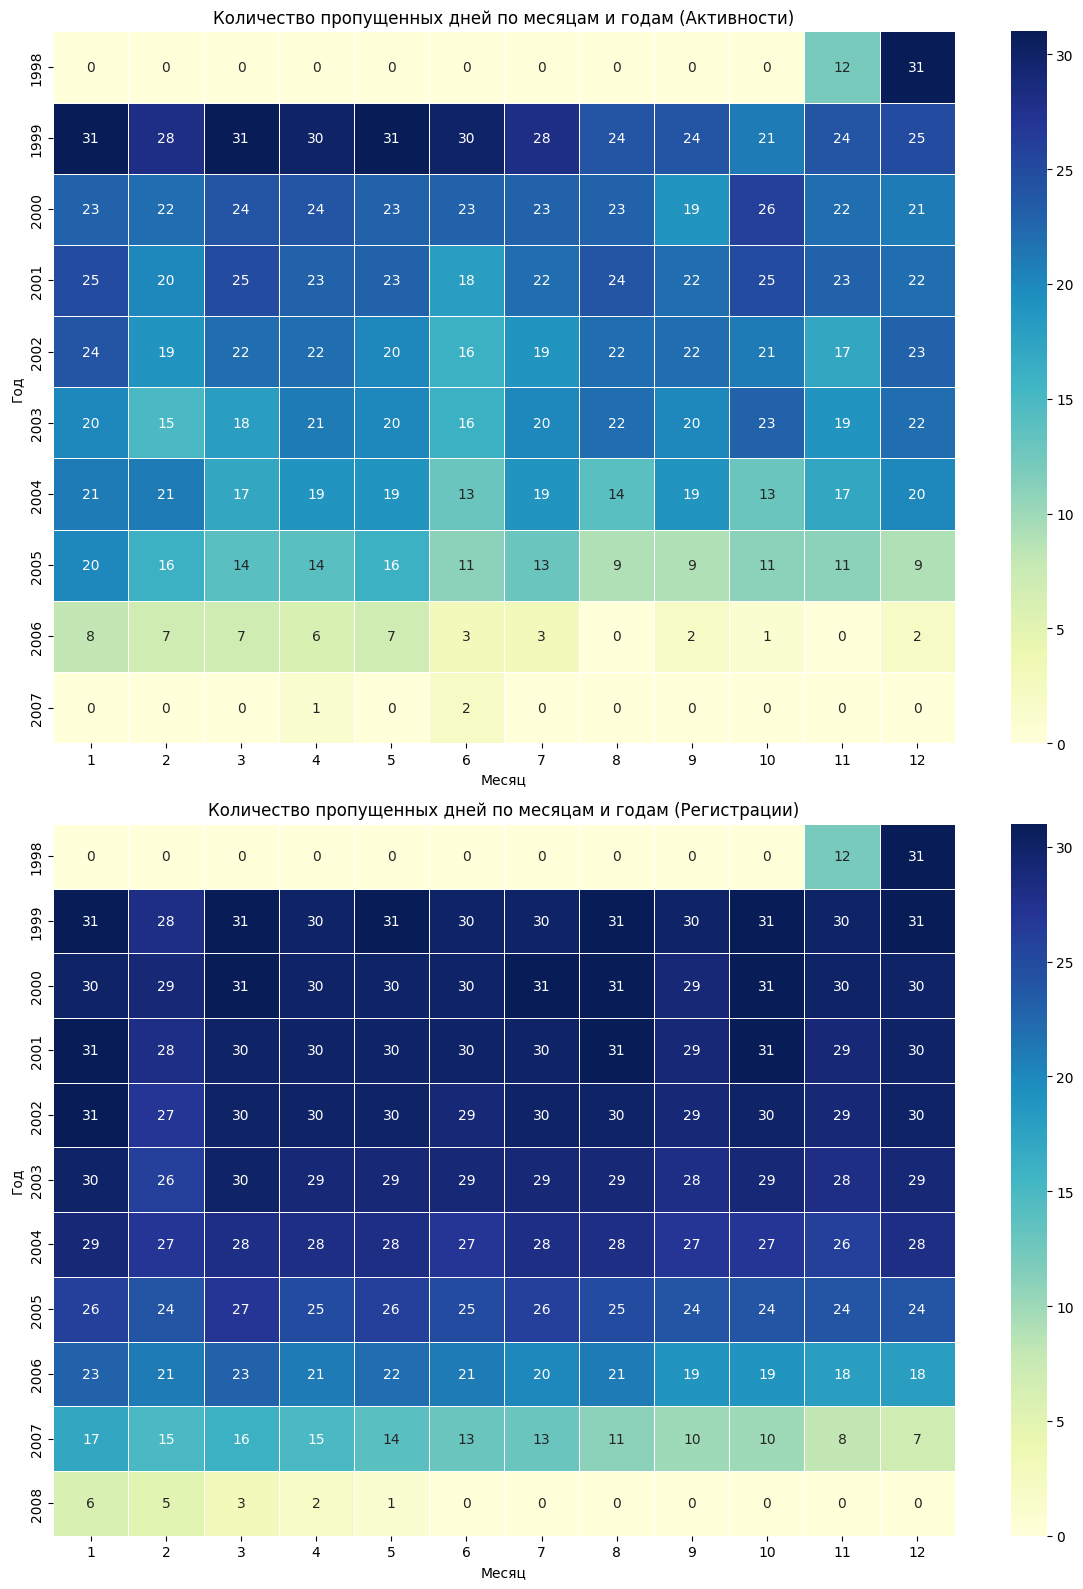

Последняя пропущенная дата активности : 2007-06-26 00:00:00
Последняя пропущенная дата регистрации: 2008-05-14 00:00:00


In [12]:
"""
Просмотр активности игроков:
1) Вывод тепловой карты с информацией о "пропущенных днях".
2) Определение, когда игра начала набирать популярность.

Визуализируем данные авторизации (auth_data) и регистрации (reg_data).
Также выводим последнюю "год-месяц-день" неактивного (пропущенного) дня для обоих DataFrame.

Это поможет понять, когда игра начала набирать популярность.
"""

def missed_dates(df_data: pd.DataFrame, date_col: str, start_date: str = '1998-11-18', end_date: str = '2020-09-23'):
    """
    Находит пропущенные даты в данных и возвращает количество пропущенных дней по годам и месяцам
    и последнюю пропущенную дату.

    Параметры:
    df_data (pd.DataFrame): DataFrame с данными, содержащими колонку с датами.
    date_col (str): Название колонки с датами.
    start_date (str): Начальная дата для анализа (в формате 'YYYY-MM-DD').
    end_date (str): Конечная дата для анализа (в формате 'YYYY-MM-DD').

    Возвращает:
    Tuple[pd.DataFrame, pd.Timestamp]: Количество пропущенных дней по годам и месяцам, 
    и последняя пропущенная дата.
    """
    # Преобразование колонок с датами в формат datetime
    df_data[date_col] = pd.to_datetime(df_data[date_col])
    
    # Фильтрация данных для заданного диапазона дат
    df_data_filtered = df_data[(df_data[date_col] >= start_date) & (df_data[date_col] <= end_date)]
    
    # Добавление колонок с годом, месяцем и днем
    df_data_filtered['year'] = df_data_filtered[date_col].dt.year
    df_data_filtered['month'] = df_data_filtered[date_col].dt.month
    df_data_filtered['day'] = df_data_filtered[date_col].dt.day
    
    # Создание DataFrame с полным диапазоном дат
    full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    full_date_df = pd.DataFrame(full_date_range, columns=['date'])
    
    # Добавление колонок с годом, месяцем и днем для полного диапазона дат
    full_date_df['year'] = full_date_df['date'].dt.year
    full_date_df['month'] = full_date_df['date'].dt.month
    full_date_df['day'] = full_date_df['date'].dt.day
    
    # Проверка на наличие пропущенных дат
    merged_data = full_date_df.merge(df_data_filtered, how='left', left_on=['year', 'month', 'day'], right_on=['year', 'month', 'day'], suffixes=('', '_auth'))
    missing_dates = merged_data[merged_data[date_col + '_auth'].isnull()]['date']
    
    # Добавление колонок с годом и месяцем в данные о пропущенных датах
    missing_dates_df = pd.DataFrame(missing_dates, columns=['date'])
    missing_dates_df['year'] = missing_dates_df['date'].dt.year
    missing_dates_df['month'] = missing_dates_df['date'].dt.month
    
    # Подсчет количества пропущенных дней по годам и месяцам
    missing_count = missing_dates_df.groupby(['year', 'month']).size().unstack(fill_value=0)
    
    # Последняя пропущенная дата
    last_missing_date = missing_dates.max() if not missing_dates.empty else None
    
    return missing_count, last_missing_date

# Преобразование колонок с датами в формат datetime
auth_data['date'] = pd.to_datetime(auth_data['date'])
reg_data['date'] = pd.to_datetime(reg_data['date'])

# Получение данных для авторизаций и регистраций
missing_count_auth, last_missing_auth_date = missed_dates(auth_data, 'date')
missing_count_reg, last_missing_reg_date = missed_dates(reg_data, 'date')

# Построение графиков
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# Визуализация пропущенных дней для данных авторизаций
sns.heatmap(missing_count_auth, cmap='YlGnBu', linewidths=.5, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Количество пропущенных дней по месяцам и годам (Активности)')
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Год')

# Визуализация пропущенных дней для данных регистраций
sns.heatmap(missing_count_reg, cmap='YlGnBu', linewidths=.5, annot=True, fmt='d', ax=axes[1])
axes[1].set_title('Количество пропущенных дней по месяцам и годам (Регистрации)')
axes[1].set_xlabel('Месяц')
axes[1].set_ylabel('Год')

plt.tight_layout()
plt.show()

# Вывод последних пропущенных дат авторизации и регистрации
print(f"Последняя пропущенная дата активности : {last_missing_auth_date}")
print(f"Последняя пропущенная дата регистрации: {last_missing_reg_date}")

#### Пропущенные дни авторизаций
- Наибольшее количество пропущенных дней наблюдается в период с 1999 по 2006 годы.
- В 2007 году количество пропущенных дней значительно уменьшилось.
- Последняя пропущенная дата авторизации: 2007-06-26.
#### Пропущенные дни регистраций
- В период с 1999 по 2007 годы наблюдается большое количество пропущенных дней, аналогично данным авторизаций.
- Наибольшее количество пропущенных дней зафиксировано в 2004 и 2005 годах.
- Последняя пропущенная дата регистрации: 2006-05-31.

### 🌴 UID и user_id что это?

#### Один из первых вопросов при визуальном анализе данных: 

- ##### *Есль ли в списке reg_data административные UID?*
- ##### *ab_test.user_id, это UID пользователей или нет?*

Проведем анализ для получения ответа на данный вопрос.

#### 🍬 Есль ли в списке reg_data административные UID?

Учтем пару важных фактов, а именно:
- В Unix-подобных операционных системах пользователи идентифицируются идентификаторами пользователя (UID)
- UID с 1 по 100 по соглашению резервируются под системные нужды; некоторые руководства рекомендуют резервировать UID со 101 по 499 (в Red Hat) или даже 999 (в Debian).

In [13]:
"""
Функция считает количество пропущенных UID.
UID нумеруется последовательно, и +1 присваивается новому пользователю.
"""

def find_missing_numbers(column: List[int]) -> List[int]:
    """
    Находит отсутствующие числа в колонке, предполагая, что числа должны быть последовательно 
    упорядочены от минимального до максимального значения.

    Параметры:
    column (List[int]): Список чисел, в котором нужно найти пропущенные значения.

    Возвращает:
    List[int]: Отсортированный список пропущенных чисел.
    """
    min_val = column.min()
    max_val = column.max()
    full_range = set(range(min_val, max_val + 1))
    actual_numbers = set(column)
    missing_numbers = sorted(full_range - actual_numbers)
    return missing_numbers

# Проверка столбца 'number'
missing_numbers_reg_data = find_missing_numbers(reg_data['uid'])

# Проверка столбца 'number'
missing_numbers_auth = find_missing_numbers(auth_data['uid'])

# Проверка столбца 'number'
missing_numbers_ab_test = find_missing_numbers(ab_test['user_id'])

# Вывод результата
print(len(missing_numbers_auth))
print(len(missing_numbers_reg_data))
print(len(missing_numbers_ab_test))

110622
110622
0


В reg_data и auth_data одинаковое колличество отсутствующих uid, а в ab_test нет никаких пропущенных uid.

In [14]:
"""
Если есть UID за которыми закреплены администраторы то они должны быть в reg_data
Проверяем только missing_numbers_reg_data
"""

# Поиск админов по большому разрыву во UID
missing_numbers = list(missing_numbers_reg_data)

# Создаем новый список, вычитая прошлое число и записывая абсолютное значение результата
differences = [abs(missing_numbers[i] - missing_numbers[i-1]) for i in range(1, len(missing_numbers))]

# Вывод результата
for i in differences:
    if i>99:
        print(i)

105
124
106
101


Максимальное количество пропущенных подряд uid составляет 124, но сказать точно что именно этот интервал закреплен за администраторами uid нельзя.

#### 🎃 Итог:
- Всего 110622 uid играков были удаленны, по разнм причинам, политики компании, не активности игрока и т.п. Так как нет достаточной информации предположим что отсутствие некоторых uid связана с удалением аккаунта игрока самим играком или компанием и полностью стерта.
- Опредплить UID админов или их количество непредставляется вазможным так как не соблюдаются соглашении о резервироваии UID от 0 по 100 или любая другая резервация.
- UID с 1 по 100 по соглашению резервируются под системные нужды; некоторые руководства рекомендуют резервировать UID со 101 по 499 (в Red Hat) или даже 999 (в Debian).
- Было замеченнно 4 дистанции длинной от 101 до 124 отсутствующих UID последовательно, но нельзя утверждать что они или любые другие UID, кроме 0 UID, закреплены за *админами.
- По колличеству роста уникальных играков и по заданию проекта: ***"Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения"*** можно утверждать что над игрой работает не один человек, а целая команда и за некоторыми из них точно закреплено некоторое количество UID.
- UID *админов никак не могут учитываться в общей БД играков, они должны быть отдельно от играков. И из-за этого в нашей бд, где:

    1. reg_data - данные о времени регистрации играков.
  
    2. auth_data - данные о времени захода пользователей в игру.
  
    3. ab_test - результаты A/B теста.

  Не может оказаться UID *админов ни в одной предоставленной БД так как все эти БД предназначенны строго для играков. Так же этот факт подтверждается текстом из задания 1, где четко проговаривается что в reg_data только играки:

  **Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).**

#### Заключение:
Предоставленные файлы содержат UID исключительно играков.

### 🍁 ab_test.user_id, это UID пользователей или нет?¶

In [15]:
"""
Мерджим два dataframe что бы установить какие пользователи попали в аб тест
ab_test -> auth_data
ab_test['user_id'] auth_data['auth_ts']
"""

merged_data_reg_data = pd.merge(ab_test, reg_data, left_on='user_id', right_on='uid', how='inner')
merged_data_reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364555 entries, 0 to 364554
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    364555 non-null  int64         
 1   revenue    364555 non-null  int64         
 2   testgroup  364555 non-null  object        
 3   uid        364555 non-null  int64         
 4   date       364555 non-null  datetime64[ns]
 5   time       364555 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 16.7+ MB


Резюмируем:
- Видим, что в merged_data_reg_data всего 364555 строк, в то время как в ab_test 404770 строк. Пропало 40215

Нужно провести дополнительный анализ:

In [16]:
# Собираем список уникальных *id и считаем их количество
list_merged_data_reg_data = list(merged_data_reg_data.user_id.unique())
len_merged_data_reg_data = len(merged_data_reg_data.user_id.unique()) # len_merged_data_reg_data -> 364555

list_ab_test = ab_test.user_id.unique()
len_ab_test =  len(ab_test.user_id.unique()) # len_ab_test -> 404770

# Считаем количество отсутствующих *id 
b = set(list_merged_data_reg_data)
n = set(list_ab_test)

m = n - b
m = list(m)
len(m)

40215

- В len_merged_data_reg_data, 364555 уникальных играков.
- В len_ab_test, 404770 уникальных играков.
- Всего видем 40215 несовпадений .

Продолжаем анализировать 40215 user_id:

In [17]:
# Проверяем отсутсвующие id по auth_data
list_auth_data = list(auth_data.uid.unique())
p = set(list_auth_data)
o = n - p

# Ищем *id которых нет в списках
u = set(o) - set(m)
u1 = set(m) - set(o) 

print(len(o))
print(list(u))
print(list(u1))

40215
[]
[]


В auth_data отсутсвует 40215 id

In [18]:
# Проверка, маленькую часть данных, на наличие или отсутствие id
print(auth_data.uid.unique()[:20])
print(reg_data.uid.unique()[:20])
print(ab_test.user_id.unique()[:20])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


Как можно видеть отсутствует в ab_test 17ый user_id

In [19]:
ab_test.groupby('testgroup').size()

testgroup
a    202103
b    202667
dtype: int64

Резюмирую:
- ab_test.user_id не равен reg_data.uid или auth_data.uid
- Данные в ab_test.user_id это последовательный счет от 1 до 404770. Без дублирующихся чисел.
- В reg_data.uid и auth_data.uid данные идут по порядку от меньшего uid к большему uid, но с отсутствием некоторых uid, пример: ...15, 16, 18, 19... Отсутсвует 17. В то время как в ab_test.user_id все идет четко по порядку.
- Нельзя свизать ab_test.user_id с конкретными игроками так как в ab_test.user_id есть *id котоых нет в reg_data.uid или auth_data.uid.
- Невазможно определить период проводимого АБ теста.

# ❄️ Этап 3: Решение заданий

## 🍂 Задание 1

Текст задани: **Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)**

### Характеристика reg_data
- reg_data - данные о времени регистрации
- Значения столбцов:
  
        reg_ts - время/дата регистрации игрока в формате unix time
  
        uid - идентификатор пользователя в формате unix
    
        date - год-месяц-дата регистрации
  
        time - часы-минуты-секунды регистрации
        
- Всего 1 000 000 уникальных играков

### Знакомство с данными
Перед тем как считать Retention узнаем данные лучше

###     Визуализируем количество регестраций новых играков

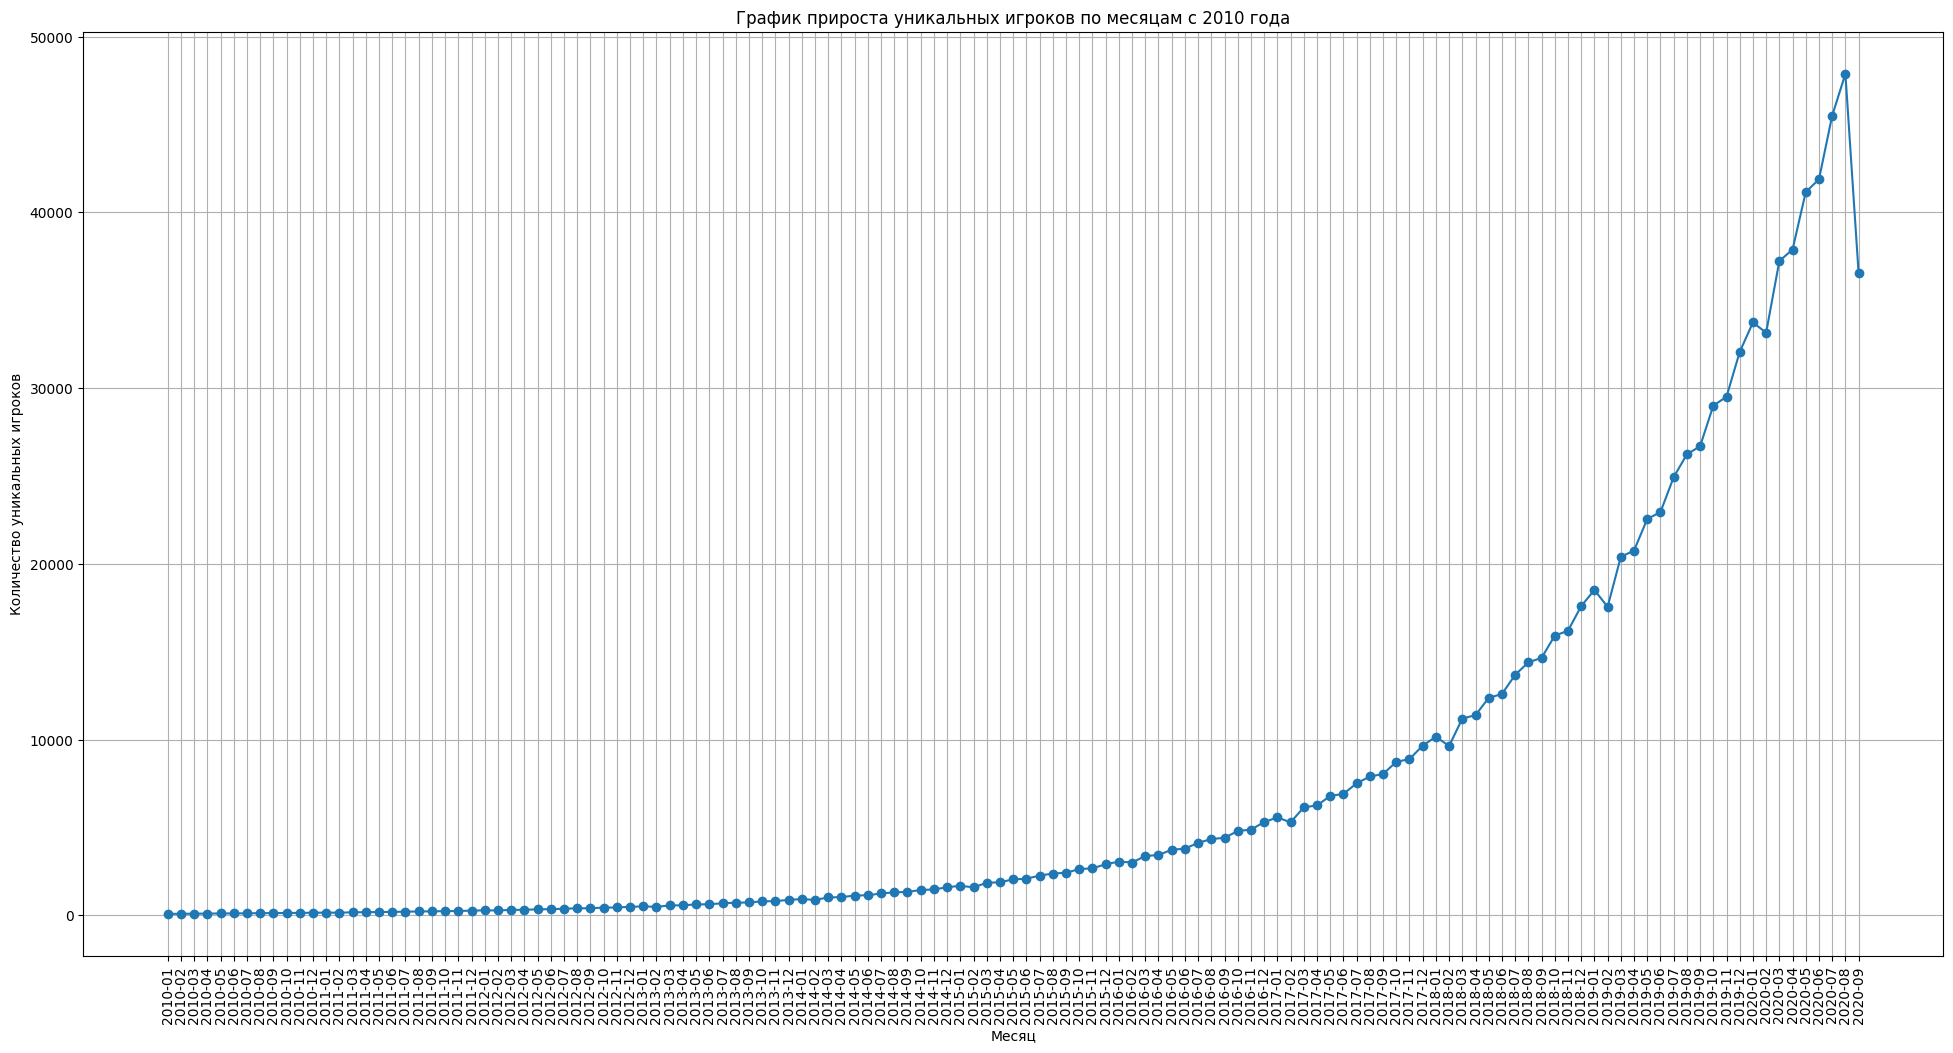

In [20]:
# Добавляем столбец с месяцем регистрации
reg_data['reg_month'] = reg_data['date'].dt.to_period('M')

# Фильтруем данные с 2010 года
reg_data_2010 = reg_data[reg_data['date'] >= '2010-01-01']

# Считаем количество уникальных пользователей по месяцам
monthly_growth_2010 = reg_data_2010.groupby('reg_month')['uid'].nunique()

# Строим график прироста уникальных игроков по месяцам с 2010 года
plt.figure(figsize=(24, 12))
plt.plot(monthly_growth_2010.index.astype(str), monthly_growth_2010.values, marker='o')
plt.title('График прироста уникальных игроков по месяцам с 2010 года')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных игроков')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### Февраль

Замедление прироста уникальных пользователей в феврале может быть обусловлено различными факторами, но логичное объяснение заключается в том, что февраль является самым коротким месяцем. Это естественным образом может приводить к меньшему количеству регистраций из-за меньшего числа дней. 
Проверим количество регистраций по месяцам в среднем за день.

In [21]:
# Преобразование столбца date в формат datetime
reg_data['date'] = pd.to_datetime(reg_data['date'])

# Извлечение года и месяца из столбца date
reg_data['year'] = reg_data['date'].dt.year
reg_data['month'] = reg_data['date'].dt.month

# Группировка данных по годам и месяцам, подсчет регистраций
monthly_registrations = reg_data.groupby(['year', 'month']).size().reset_index(name='registrations')

# Расчет среднего количества дней в месяце (с учетом високосных лет)
days_in_month = {
    1: 31, 2: 28.25, 3: 31, 4: 30, 5: 31, 6: 30,
    7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31
}

# Добавление столбца с количеством дней в месяце
monthly_registrations['days_in_month'] = monthly_registrations['month'].apply(lambda x: days_in_month[x])

# Расчет среднего количества регистраций в день
monthly_registrations['avg_registrations_per_day'] = monthly_registrations['registrations'] / monthly_registrations['days_in_month']

# Фильтрация данных для февраля
february_registrations = monthly_registrations[monthly_registrations['month'] == 2]

# Вывод данных для всех месяцев и для февраля
print("Все месяцы:")
print(monthly_registrations)
print("\nФевраль:")
print(february_registrations)

# Сравнение среднего количества регистраций в день между февралем и другими месяцами
mean_february_registrations = february_registrations['avg_registrations_per_day'].mean()
mean_other_months_registrations = monthly_registrations[monthly_registrations['month'] != 2]['avg_registrations_per_day'].mean()

print(f"\nСреднее количество регистраций в день в феврале: {mean_february_registrations:.2f}")
print(f"Среднее количество регистраций в день в другие месяцы: {mean_other_months_registrations:.2f}")

if mean_february_registrations < mean_other_months_registrations:
    print("\nВ феврале наблюдается проседание тренда.")
else:
    print("\nВ феврале не наблюдается проседание тренда.")

Все месяцы:
     year  month  registrations  days_in_month  avg_registrations_per_day
0    1998     11              1           30.0                   0.033333
1    1999      7              1           31.0                   0.032258
2    2000      1              1           31.0                   0.032258
3    2000      5              1           31.0                   0.032258
4    2000      9              1           30.0                   0.033333
..    ...    ...            ...            ...                        ...
230  2020      5          41159           31.0                1327.709677
231  2020      6          41880           30.0                1396.000000
232  2020      7          45502           31.0                1467.806452
233  2020      8          47882           31.0                1544.580645
234  2020      9          36540           30.0                1218.000000

[235 rows x 5 columns]

Февраль:
     year  month  registrations  days_in_month  avg_registrations_

### Вывод по данным

Среднее количество регистраций в день в феврале: 134.41

Среднее количество регистраций в день в другие месяцы: 140.25

### Интерпретация

На основании этих данных можно сделать следующий вывод:

- В феврале действительно наблюдается проседание тренда регистраций. Среднее количество регистраций в день в феврале (134.41) меньше, чем в другие месяцы (140.25).

### Сентябрь 2020-09
Видим что произашел резкий спад в этом месяце, для того чтобы узнать причину просмотрим повнимательнее на этот месяц. 


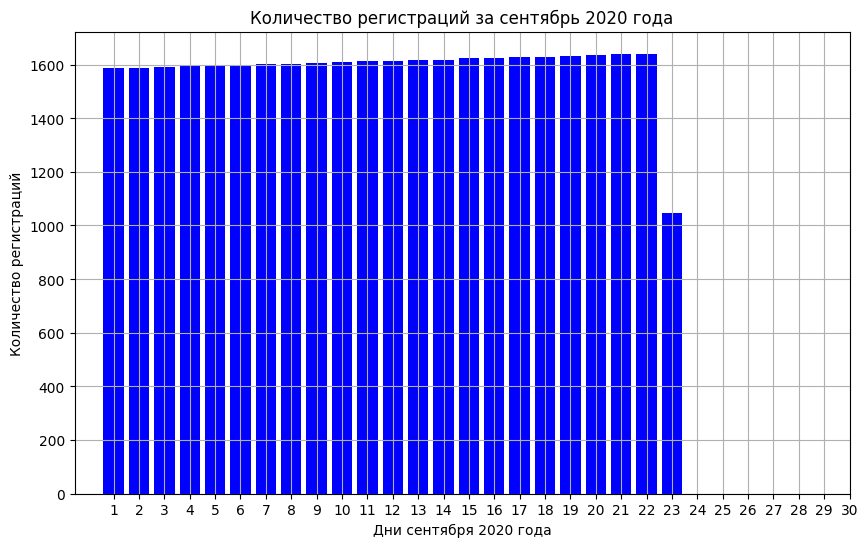

In [22]:
# Преобразование столбца 'date' в формат datetime
reg_data['date'] = pd.to_datetime(reg_data['date'])

# Фильтрация данных за сентябрь 2020 года
sept_2020_data = reg_data[(reg_data['date'] >= '2020-09-01') & (reg_data['date'] <= '2020-09-30')]

# Подсчет количества регистраций по дням
registrations_per_day = sept_2020_data['date'].dt.day.value_counts().sort_index()

# Построение графика
plt.figure(figsize=(10, 6))
plt.bar(registrations_per_day.index, registrations_per_day.values, color='blue')
plt.xlabel('Дни сентября 2020 года')
plt.ylabel('Количество регистраций')
plt.title('Количество регистраций за сентябрь 2020 года')
plt.xticks(range(1, 31))
plt.grid(True)
plt.show()

### Итог

Месяц неполностью заполнен. При анализе данных я обнаружил, что максимальная дата регистрации в нашем наборе данных — 23 сентября 2020 года. На дополнительном графике видно резкое снижение числа регистраций после 23-го числа. Однако, это снижение несущественно, так как касается лишь одного дня из множества.

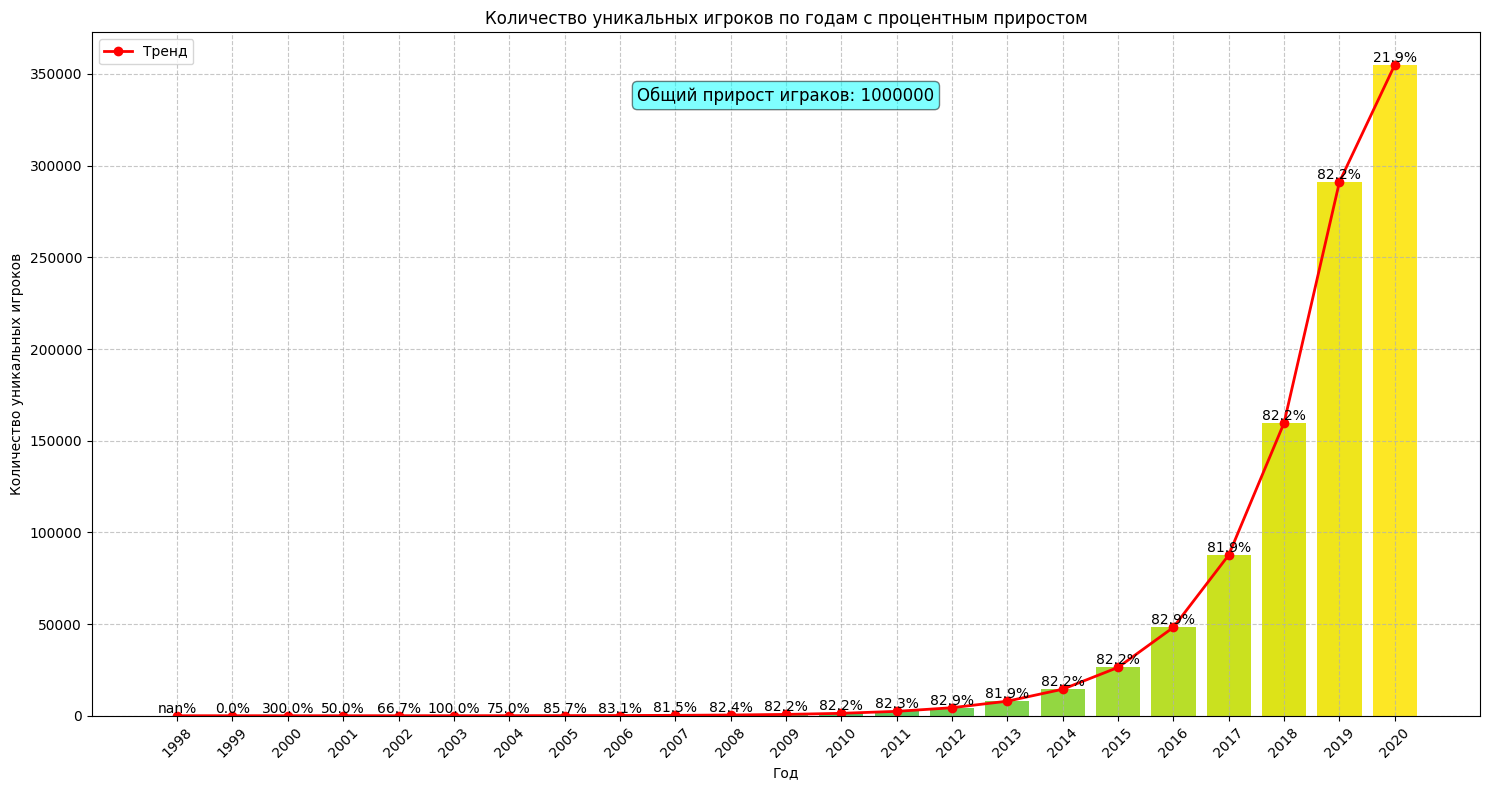

In [23]:
# Добавляем столбец с годом регистрации
reg_data['reg_year'] = reg_data['date'].dt.year

# Фильтруем данные с 1998 года
reg_data_1998 = reg_data[reg_data['date'] >= '1998-01-01']

# Считаем количество уникальных пользователей по годам
yearly_growth = reg_data_1998.groupby('reg_year')['uid'].nunique()

# Вычисляем процентный прирост новых игроков по сравнению с предыдущим годом
growth_percentages = yearly_growth.pct_change() * 100

# Создаем градиентную цветовую карту от более светлого к менее светлому синему
##colors = plt.cm.Blues_r(np.linspace(0.2, 1, len(yearly_growth)))
colors = plt.cm.viridis(np.linspace(0.4, 1, len(yearly_growth)))


# Строим столбчатую диаграмму с аннотациями и линией тренда
plt.figure(figsize=(15, 8))
bars = plt.bar(yearly_growth.index.astype(str), yearly_growth.values, color=colors)
plt.plot(yearly_growth.index.astype(str), yearly_growth.values, marker='o', color='red', linestyle='-', linewidth=2, label='Тренд')
plt.title('Количество уникальных игроков по годам с процентным приростом')
plt.xlabel('Год')
plt.ylabel('Количество уникальных игроков')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend(loc='upper left')

# Добавляем аннотации с процентным приростом новых игроков по сравнению с предыдущим годом
for i, bar in enumerate(bars):
    growth_percentage = growth_percentages.iloc[i]
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{growth_percentage:.1f}%', 
             ha='center', va='bottom', fontsize=10, color='black')

# Добавляем текстовую аннотацию с общим приростом
total_growth = (yearly_growth.iloc[-1] - yearly_growth.iloc[0]) / yearly_growth.iloc[0] * 100
plt.annotate(f'Общий прирост играков: {len(reg_data.uid.unique())}', xy=(0.5, 0.9), xycoords='axes fraction',
             fontsize=12, ha='center', bbox=dict(boxstyle='round,pad=0.3', fc='cyan', alpha=0.5))

plt.tight_layout()
plt.show()

### Вывод по графику

На графике показано количество уникальных игроков по годам с процентным приростом.

**Основные наблюдения:**
1. **Резкий рост числа игроков:**
   - Начиная с 2016 года, наблюдается стремительный рост количества уникальных игроков.
   - В 2018 году прирост игроков составляет 82.2%, а к 2020 году он достигает 21.9%.
   
2. **Стабильный прирост:**
   - С 1998 по 2015 год прирост игроков был менее значительным, с редкими всплесками. Это показывает, что проект находился на стадии медленного роста или стабилизации.

3. **Экспоненциальный рост:**
   - Начиная с 2016 года, виден экспоненциальный рост, который продолжается до 2020 года. Это указывает на успешные маркетинговые стратегии или популярность игры, приведшие к значительному увеличению базы игроков.

4. **Общий прирост игроков:**
   - Общий прирост уникальных игроков за весь период составил 1,000,000.

**Вывод:**
График демонстрирует успешное развитие проекта, особенно в последние несколько лет, с резким увеличением количества уникальных игроков. Это может свидетельствовать о значительных улучшениях в продукте или маркетинговых кампаниях, которые привели к повышению интереса и вовлеченности пользователей.

### Retention

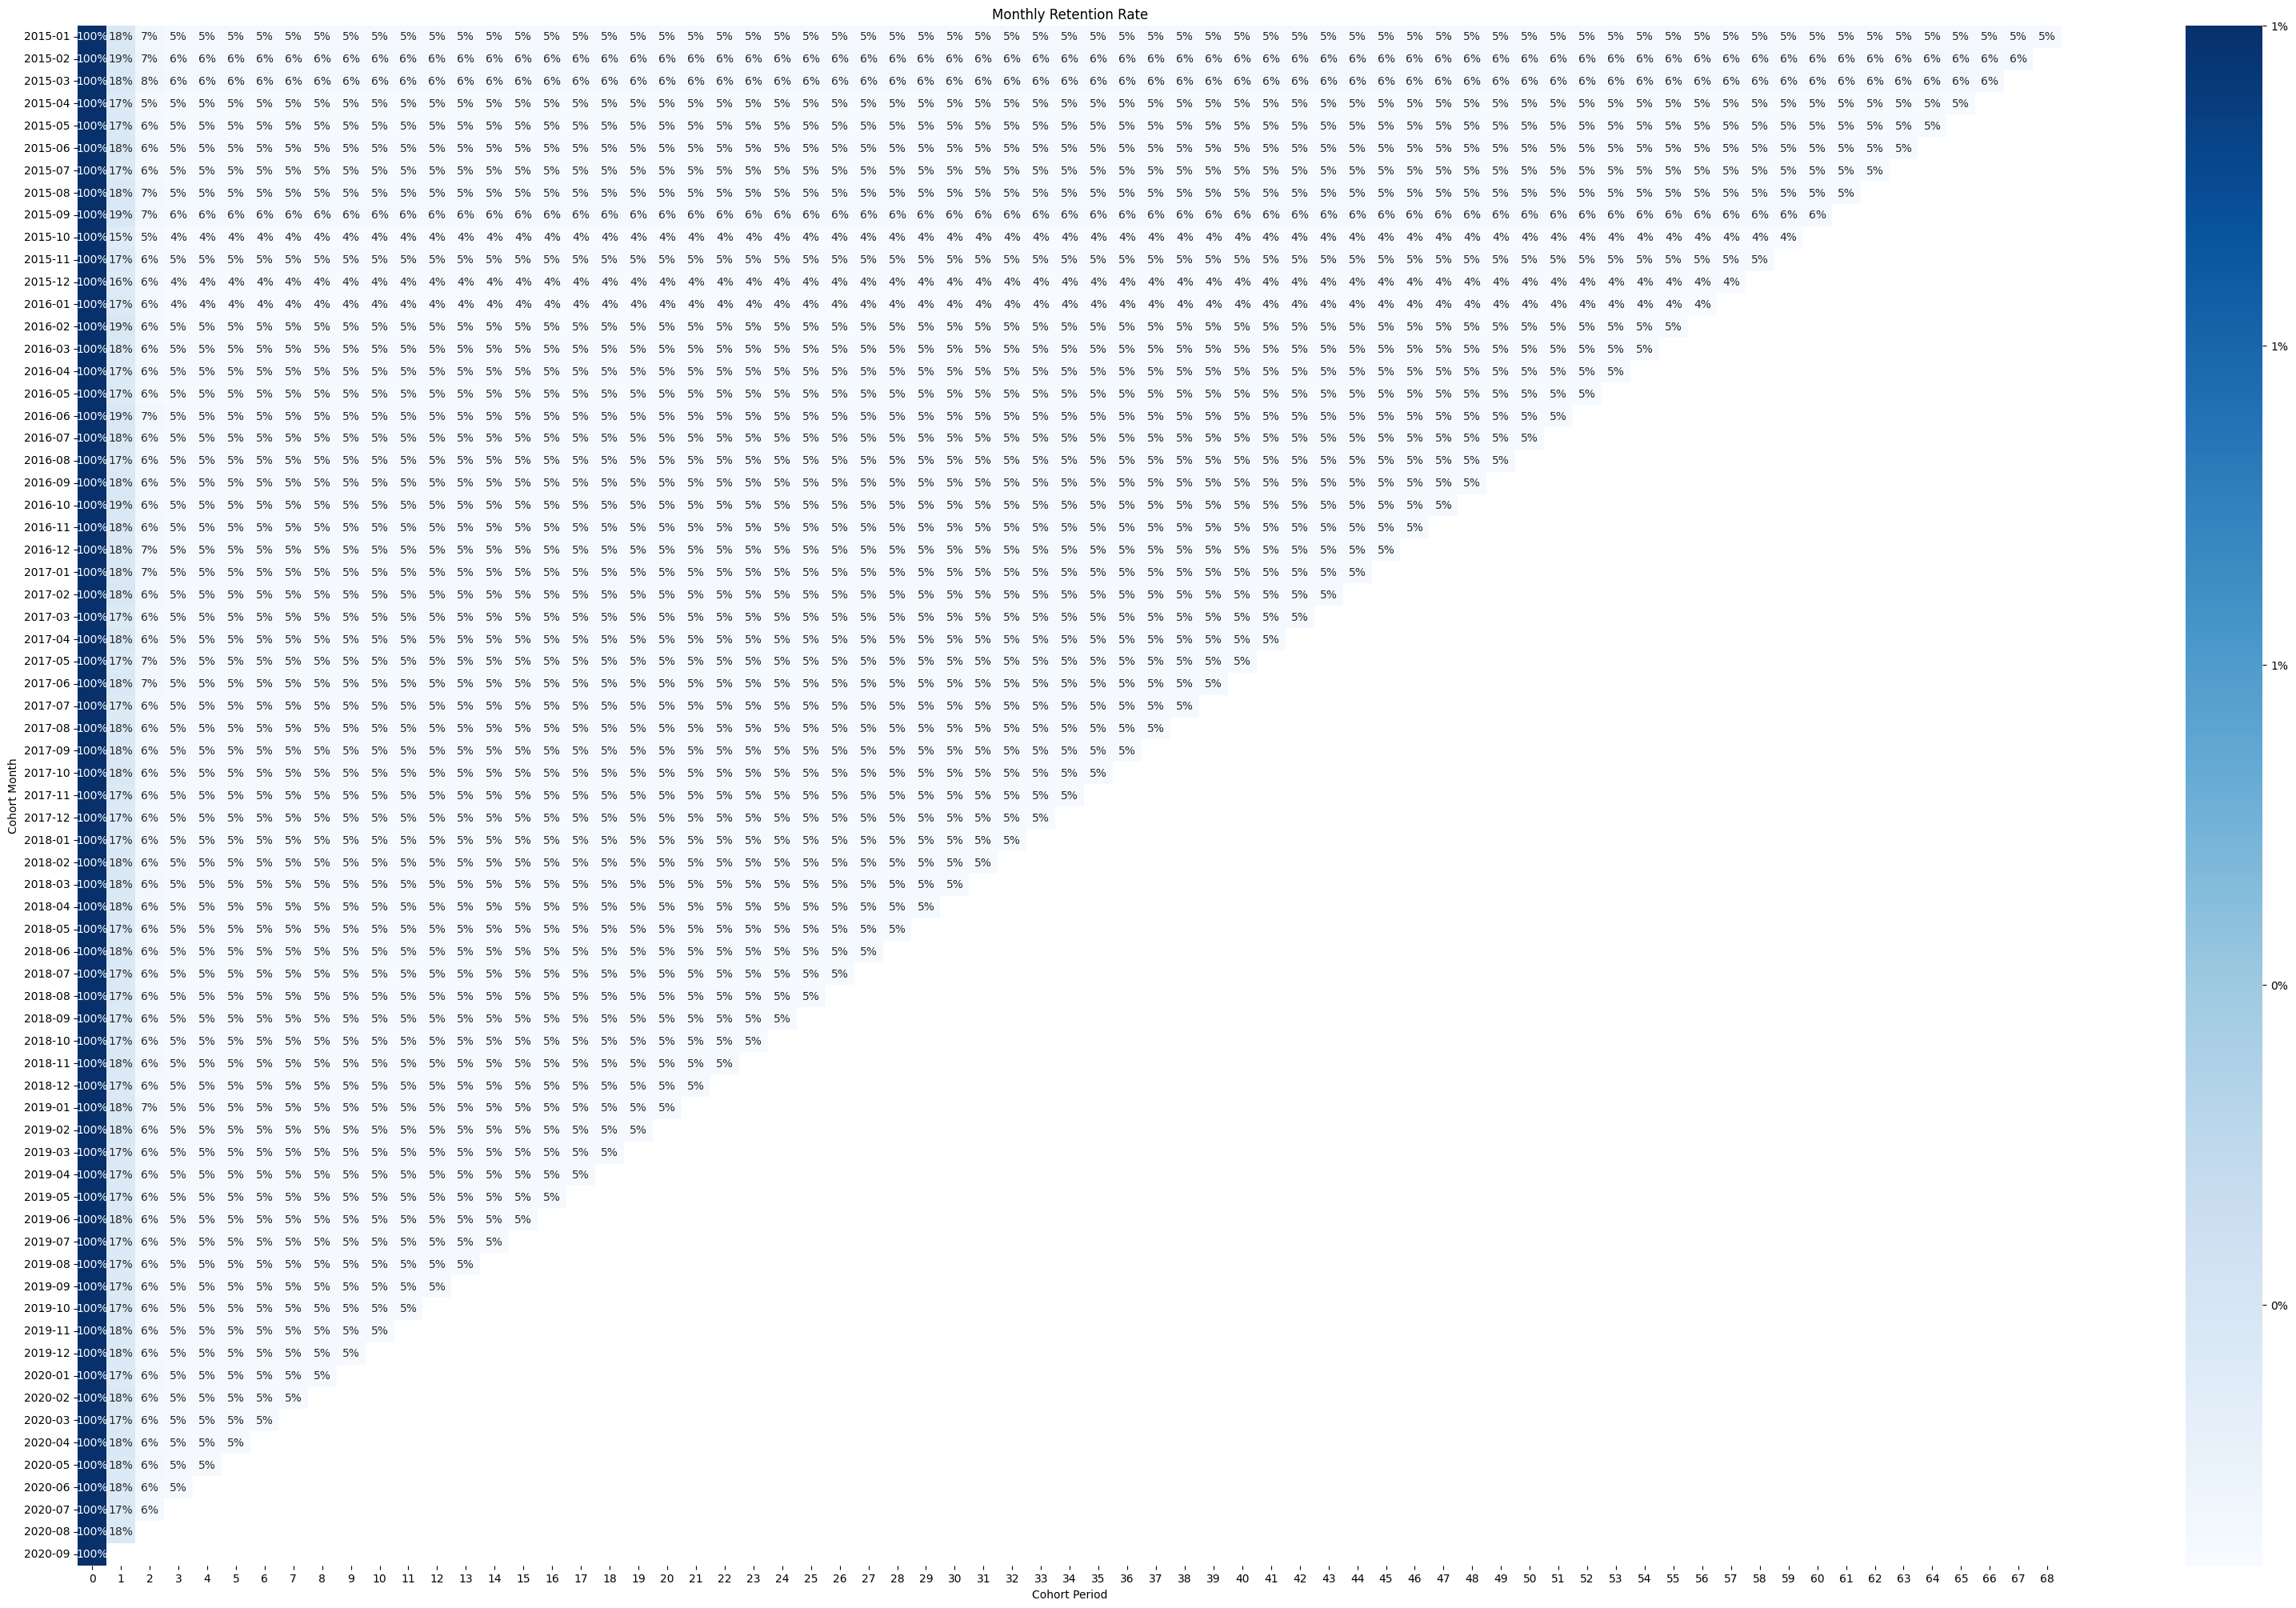

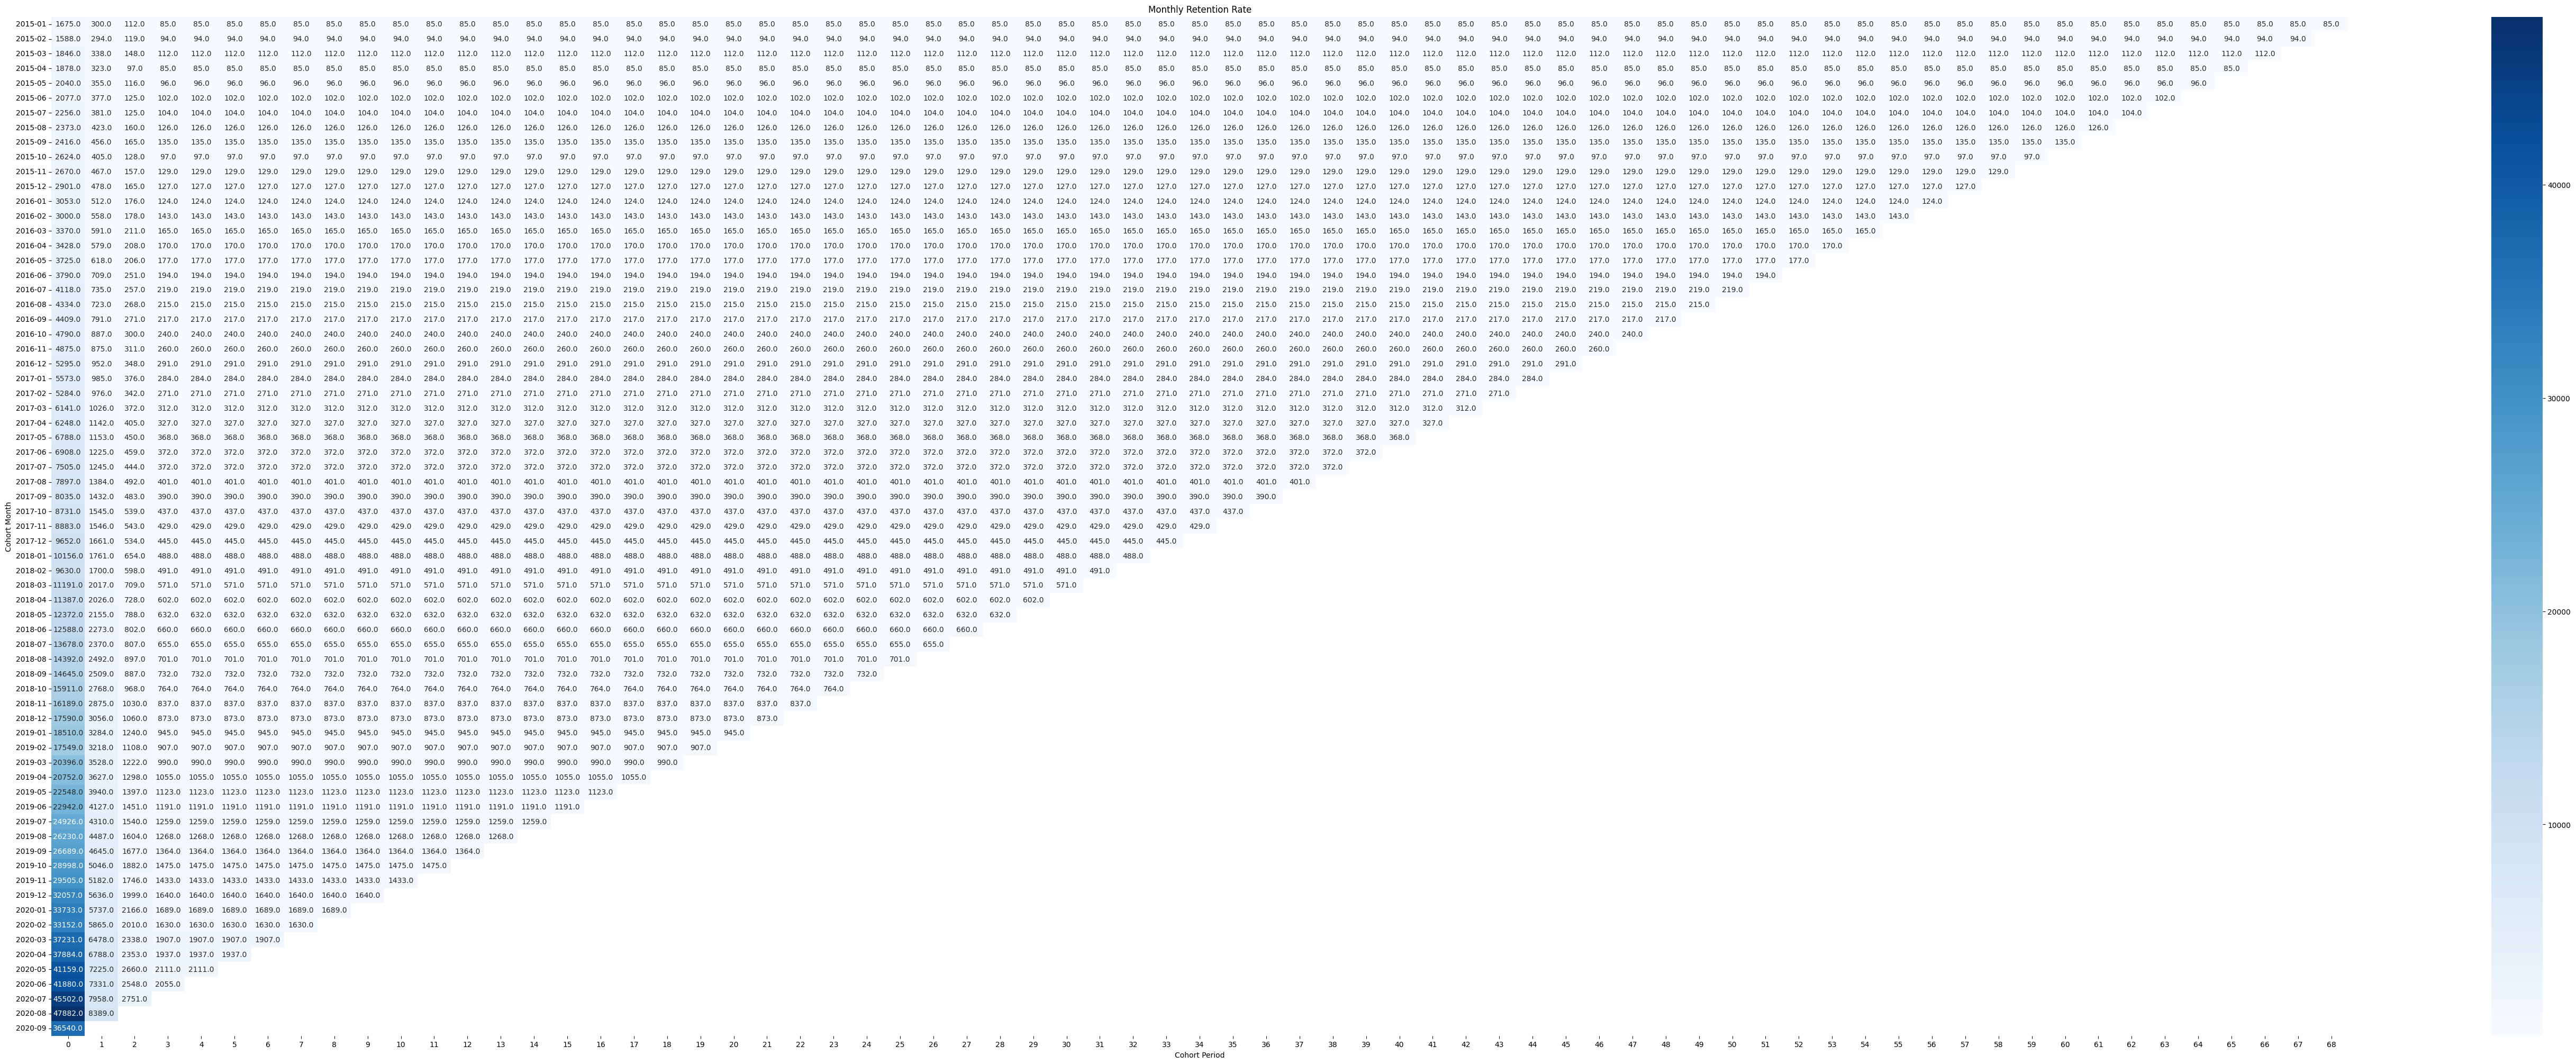

/var/folders/pf/p6mgdxlj2t50mz55hcyg73vm0000gn/T/ipykernel_2300/2356511412.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  retention_data = pd.concat([retention_data, new_row], ignore_index=True)
/var/folders/pf/p6mgdxlj2t50mz55hcyg73vm0000gn/T/ipykernel_2300/2356511412.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  retention_data = pd.concat([retention_data, new_row], ignore_index=True)


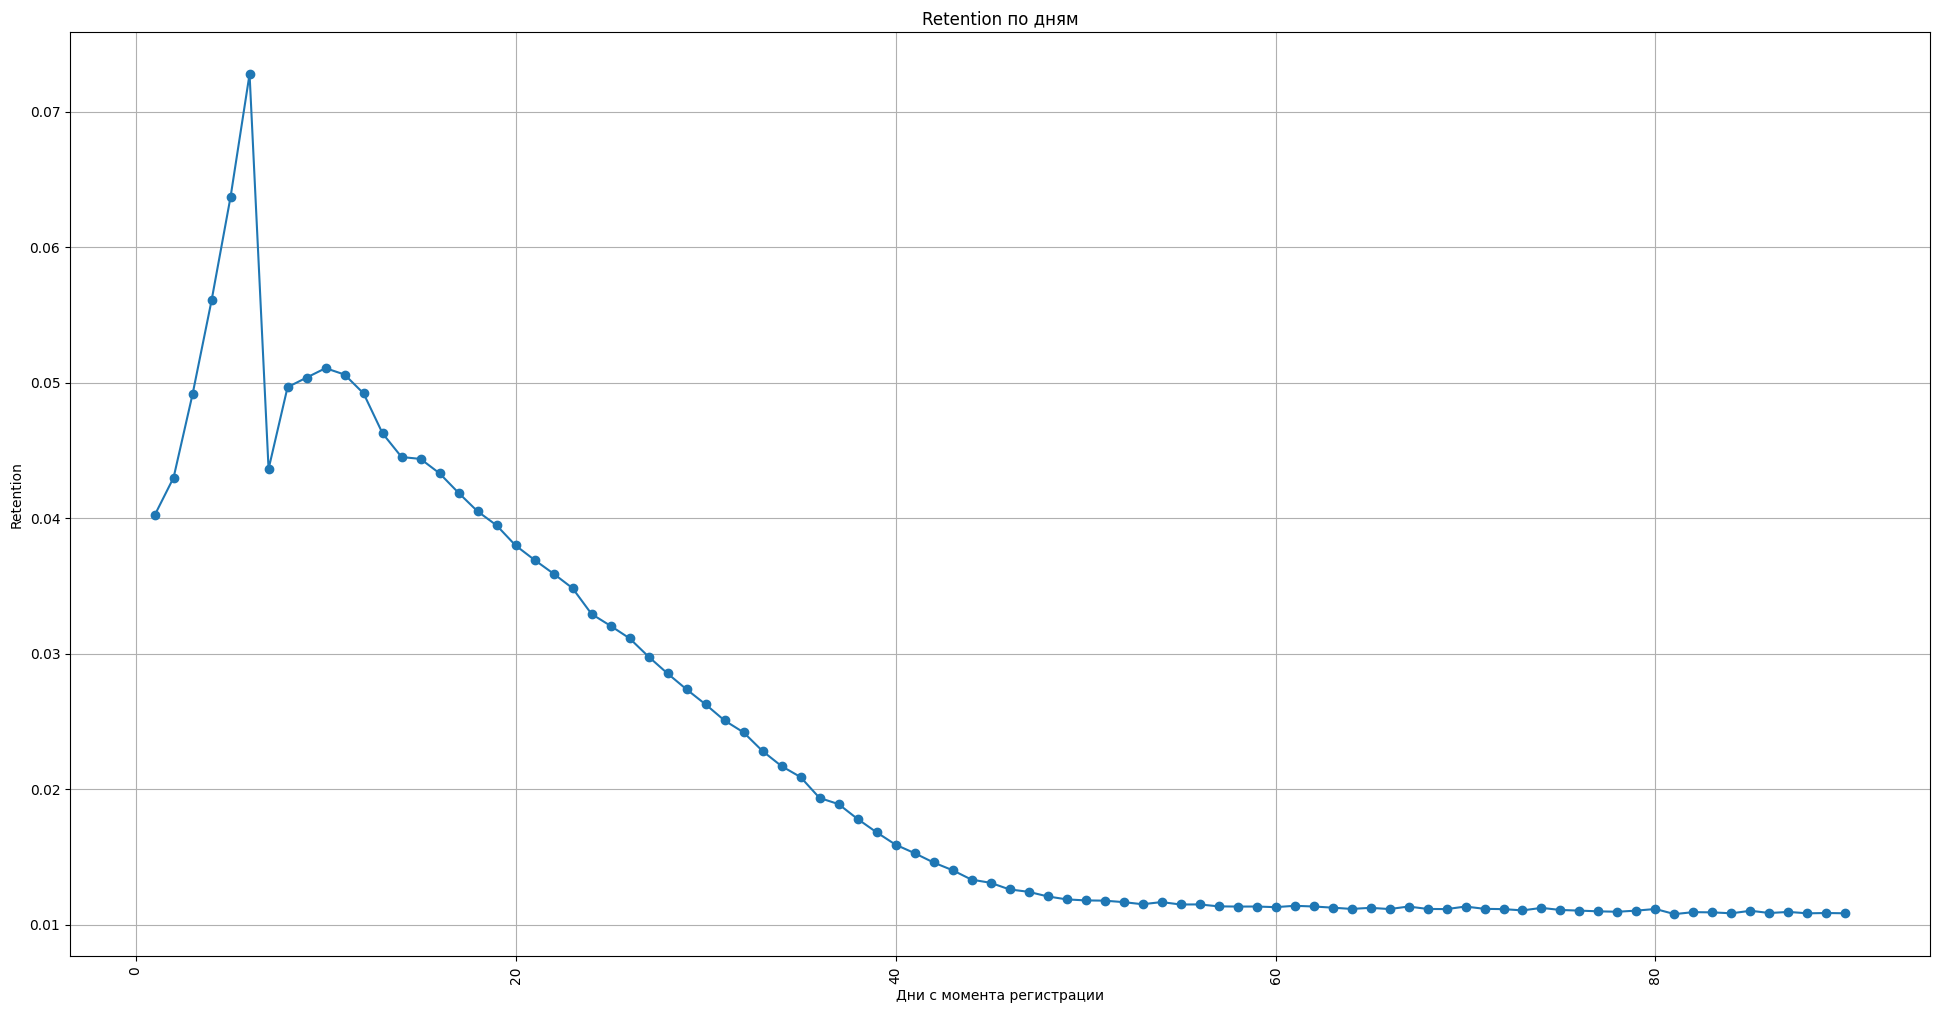

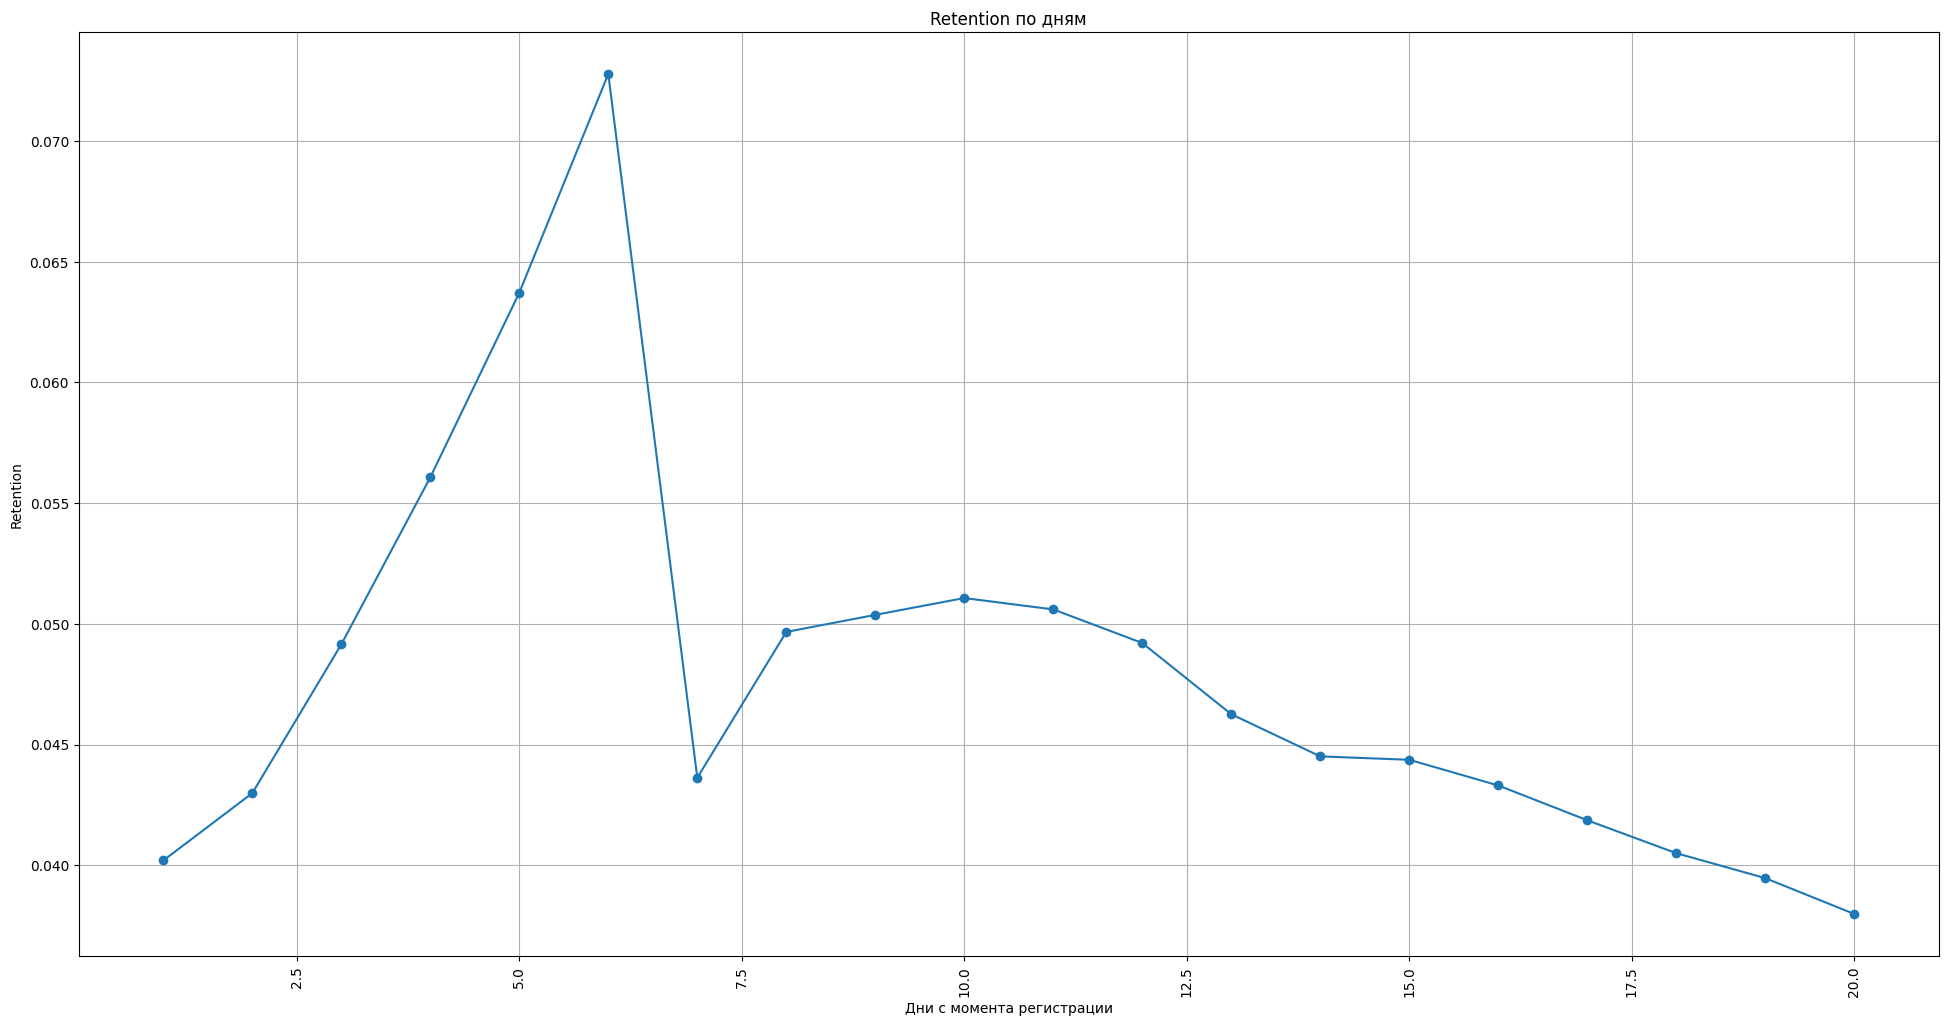

In [24]:
"""
Анализ удержания пользователей и визуализация данных:
1. Рассчитываем удержание по месяцам и визуализируем его в виде тепловой карты.
2. Рассчитываем удержание по дням и строим графики.
"""

# Создаем копии исходных данных
reg_data_copy = reg_data.copy()
auth_data_copy = auth_data.copy()

# Определяем месяц регистрации для каждого пользователя
reg_data_copy['reg_month'] = reg_data_copy['date'].dt.to_period('M')

# Объединяем данные о времени захода пользователей в игру с данными о регистрации
data = pd.merge(auth_data_copy, reg_data_copy[['uid', 'reg_month']], on='uid', how='left')

# Определяем месяц захода пользователя в игру
data['active_month'] = data['date'].dt.to_period('M')

# Создаем когорты по месяцу регистрации
cohorts = data.groupby(['reg_month', 'active_month']).agg({'uid': 'nunique'}).reset_index()

# Определяем первый месяц для каждой когорты
cohorts['period_number'] = (cohorts['active_month'] - cohorts['reg_month']).apply(lambda x: x.n)

# Создаем сводную таблицу для heatmap
cohort_pivot = cohorts.pivot_table(index='reg_month', columns='period_number', values='uid')

# Делим каждое значение на количество пользователей в когорте, чтобы получить процент
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Фильтруем данные по периоду с 2015 по 2020 год
start_date = '2015-01'
end_date = '2020-12'
filtered_reg_data = reg_data_copy[(reg_data_copy['reg_month'] >= start_date) & (reg_data_copy['reg_month'] <= end_date)]

# Пересчитываем когорты и сводную таблицу
filtered_data = pd.merge(auth_data_copy, filtered_reg_data[['uid', 'reg_month']], on='uid', how='left')
filtered_data['active_month'] = filtered_data['date'].dt.to_period('M')
cohorts = filtered_data.groupby(['reg_month', 'active_month']).agg({'uid': 'nunique'}).reset_index()
cohorts['period_number'] = (cohorts['active_month'] - cohorts['reg_month']).apply(lambda x: x.n)
cohort_pivot = cohorts.pivot_table(index='reg_month', columns='period_number', values='uid')
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Визуализация
plt.figure(figsize=(40, 25))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='Blues', cbar_kws={'format': '%.0f%%'})
plt.title('Monthly Retention Rate')
plt.xlabel('Cohort Period')
plt.ylabel('Cohort Month')
plt.show()

# Пересчитываем когорты и сводную таблицу
final_data = pd.merge(auth_data_copy, filtered_reg_data[['uid', 'reg_month']], on='uid', how='left')
final_data['active_month'] = final_data['date'].dt.to_period('M')
cohorts = final_data.groupby(['reg_month', 'active_month']).agg({'uid': 'nunique'}).reset_index()
cohorts['period_number'] = (cohorts['active_month'] - cohorts['reg_month']).apply(lambda x: x.n)
cohort_pivot = cohorts.pivot_table(index='reg_month', columns='period_number', values='uid')
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Визуализация
plt.figure(figsize=(70, 25))
sns.heatmap(cohort_pivot, annot=True, fmt='', cmap='Blues')
plt.title('Monthly Retention Rate')
plt.xlabel('Cohort Period')
plt.ylabel('Cohort Month')
plt.show()

# Создаем копии данных
reg_data_copy = reg_data.copy()
auth_data_copy = auth_data.copy()

# Преобразование строк в datetime
reg_data_copy['datetime'] = pd.to_datetime(reg_data_copy['date'].astype(str) + ' ' + reg_data_copy['time'])
auth_data_copy['datetime'] = pd.to_datetime(auth_data_copy['date'].astype(str) + ' ' + auth_data_copy['time'])

# Убираем ненужные столбцы
reg_data_copy = reg_data_copy.drop(['date', 'time'], axis=1)
auth_data_copy = auth_data_copy.drop(['date', 'time'], axis=1)

def calculate_retention(reg_data, auth_data, days):
    """
    Рассчитывает удержание пользователей по дням.

    Параметры:
    reg_data (DataFrame): Данные о регистрации пользователей.
    auth_data (DataFrame): Данные о времени захода пользователей в игру.
    days (int): Количество дней для расчета удержания.

    Возвращает:
    DataFrame: Данные об удержании пользователей.
    """
    # Объединяем данные регистрации и авторизации
    merged_data = pd.merge(auth_data, reg_data, on='uid', suffixes=('_auth', '_reg'))
    
    # Считаем разницу в днях между авторизацией и регистрацией
    merged_data['days_diff'] = (merged_data['datetime_auth'] - merged_data['datetime_reg']).dt.days
    
    # Создаем пустой DataFrame для хранения результатов
    retention_data = pd.DataFrame(columns=['day', 'retention'])
    
    for day in range(1, days + 1):
        # Считаем количество пользователей, которые вернулись в игру через определенное количество дней
        retained_users = merged_data[merged_data['days_diff'] == day]['uid'].nunique()
        # Считаем общее количество зарегистрированных пользователей
        total_users = reg_data['uid'].nunique()
        # Считаем retention
        retention = retained_users / total_users
        # Добавляем результат в DataFrame
        new_row = pd.DataFrame({'day': [day], 'retention': [retention]})
        retention_data = pd.concat([retention_data, new_row], ignore_index=True)
    
    return retention_data

def plot_retention(retention_data):
    """
    Строит график удержания пользователей.

    Параметры:
    retention_data (DataFrame): Данные об удержании пользователей.

    Возвращает:
    None
    """
    plt.figure(figsize=(24, 12))
    plt.plot(retention_data['day'], retention_data['retention'], marker='o')
    plt.title('Retention по дням')
    plt.xlabel('Дни с момента регистрации')
    plt.ylabel('Retention')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

# Пример использования
retention_data = calculate_retention(reg_data_copy, auth_data_copy, 90)
retention_data2 = calculate_retention(reg_data_copy, auth_data_copy, 20)

plot_retention(retention_data)
plot_retention(retention_data2)

### 🎃 Результат по данным Retention

#### Визуализация данных
На предоставленных графиках можно наблюдать:

1. **Когортный анализ Retention**:
   - График представляет собой таблицу, где по вертикальной оси указаны месяцы регистрации пользователей, а по горизонтальной оси — месяцы, прошедшие с момента регистрации.
   - Значения в ячейках таблицы представляют собой процент удержания пользователей для каждой когорты за определённый месяц после регистрации.

2. **График Retention по дням**:
   - Линейный график иллюстрирует процент возврата пользователей за определённый период.

#### Анализ данных
- **Первоначальное удержание**:
  - В первый месяц после регистрации Retention варьируется от 7% до 9%.
  - В первые дни после регистрации (1-5 дни) можно наблюдать высокий процент возвращения пользователей.

- **Снижение Retention**:
  - После первого месяца наблюдается снижение Retention во всех когортам.
  - После первого пика наблюдается резкое снижение Retention, что типично для большинства продуктов.

- **Сезонные колебания и стабилизация**:
  - Начиная с 4-5 месяцев, Retention стабилизируется на уровне 4-5%, что указывает на существование небольшой, но лояльной группы пользователей.
  - Начиная с 12 месяца и далее, Retention постепенно снижается до 2-3%.
  - На графике можно заметить колебания в возвращаемости пользователей на более поздних стадиях (после 10 дня), что может быть связано с различными внешними факторами.
  - Начиная с 20 дня и далее, Retention стабилизируется на низком уровне.

#### Заключение
1. **Начальный интерес**:
   - Высокий Retention в первый месяц и в первые дни после регистрации показывает, что пользователи заинтересованы в продукте сразу после регистрации. Это положительный признак.

2. **Проблемы с удержанием**:
   - Значительное снижение Retention после первого месяца и первых дней указывает на проблемы с удержанием пользователей. Это может быть связано с неудовлетворительным пользовательским опытом, недостатком функциональности или конкуренцией с другими продуктами.

3. **Ядро активных пользователей**:
   - Низкий, но стабильный уровень Retention после 4-5 месяцев и 20 дней показывает, что существует небольшая группа пользователей, которая находит продукт ценным и продолжает им пользоваться в долгосрочной перспективе.

## 🍂 Задание 2

### А/Б - тестирование

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

- Какие метрики стоит проанализировать для принятия правильного решения и как?
- Какой набор предложений можно считать лучшим?

#### 1) Какие метрики стоит проанализировать для принятия правильного решения и как?

Для принятия правильного решения следует проанализировать следующие метрики:

- **ARPU (Average Revenue Per User):** Средний доход на пользователя в обеих группах.
- **CR (Conversion Rate):** Процент пользователей, совершивших покупки.
- **ARPPU (Average Revenue Per Paying User):** Средний доход на платящего пользователя.

**ARPU**

Средний доход на одного пользователя — это показатель, который помогает понять, сколько в среднем приносит дохода один пользователь за определённый период. ARPU помогает понять доход на одного пользователя.

**Conversion Rate**

Коэффициент конверсии — это процент пользователей, которые совершили целевое действие (например, покупку) от общего числа пользователей. CR показывает, какой процент пользователей выполняет целевые действия.

**ARPPU**

Средний доход на платящего пользователя (ARPPU) — это метрика, которая измеряет средний доход, генерируемый каждым платящим пользователем за определённый период времени. Она вычисляется путём деления общего дохода от всех платежей на количество платящих пользователей за этот период. ARPPU позволяет оценить средний вклад каждого из клиентов, совершающих покупки, в общий доход компании.

#### 2) Какой набор предложений можно считать лучшим?

Набор предложений в тестовой группе можно считать лучшим, если:

1. **ARPU (Average Revenue Per User):** 
   - Увеличение ARPU на 5% в тестовой группе является статистически значимым.

2. **CR (Conversion Rate):** 
   - Процент платящих пользователей в тестовой группе выше и статистически значимее по сравнению с контрольной группой.

3. **ARPPU (Average Revenue Per Paying User):** 
   - Средний доход на платящего пользователя в тестовой группе выше и статистически значимее.

#### Гипотезы:

- **H₀**: Нет статистически значимой разницы между наборами акционных предложений по метрикам ARPU, CR и ARPPU.
- **H₁**: Один из наборов акционных предложений показывает статистически значимые улучшения по одной или нескольким ключевым метрикам ARPU, CR и ARPPU по сравнению с другими наборами.

### Проблемы с A/B тестом:

1. **Проблема с генерализацией:**
    - Данные могут не быть репрезентативными, если были собраны за короткий период или в особых условиях (например, во время акции). Нет информации о периоде сбора данных и как пользователи были распределены между контрольной и тестовой группами.
    
2. **Недостаток детализированной информации:**
    - Доступны только агрегированные данные по количеству платящих игроков и ARPU. Нет информации о распределении покупок, частоте покупок и поведении игроков до и после теста.

3. **Потенциальное смещение выборки:**
    - Выборка игроков для теста может быть неслучайной. Например, одни игрок2и могли чаще попадать в тестовую группу из-за определенных характеристик, что может искажать результаты.

4. **Влияние внешних факторов:**
    - Внешние факторы, такие как изменения в маркетинговых кампаниях, конкуренции и сезонные колебания, могут повлиять на поведение игроков и исказить результаты теста.

5. **Неучтенные факторы:**
    - Множество факторов, такие как предыдущий опыт игроков и время проведения теста, могли повлиять на результаты, но не были учтены.

### Запуск ARPU, CR, ARPPU

In [25]:
# ARPU
arpu_control = ab_test[ab_test['testgroup'] == 'a']['revenue'].mean()
arpu_test = ab_test[ab_test['testgroup'] == 'b']['revenue'].mean()

# CR
cr_control = ab_test[ab_test['testgroup'] == 'a']['revenue'].apply(lambda x: x > 0).mean()
cr_test = ab_test[ab_test['testgroup'] == 'b']['revenue'].apply(lambda x: x > 0).mean()

# ARPPU
arppu_control = ab_test[(ab_test['testgroup'] == 'a') & (ab_test['revenue'] > 0)]['revenue'].mean()
arppu_test = ab_test[(ab_test['testgroup'] == 'b') & (ab_test['revenue'] > 0)]['revenue'].mean()

# Выводы
print(f"ARPU (Control): {arpu_control}")
print(f"ARPU (Test): {arpu_test}")
print(f"Conversion Rate (Control): {cr_control}")
print(f"Conversion Rate (Test): {cr_test}")
print(f"ARPPU (Control): {arppu_control}")
print(f"ARPPU (Test): {arppu_test}")

ARPU (Control): 25.413719736965806
ARPU (Test): 26.75128659327863
Conversion Rate (Control): 0.009539690157988749
Conversion Rate (Test): 0.008906235351586593
ARPPU (Control): 2663.9984439834025
ARPPU (Test): 3003.6581717451522


### Вывод по метрикам

- **ARPU:** Тестовая группа (26.75) немного выше контрольной (25.41).
- **Конверсия:** Контрольная группа (0.95%) выше тестовой (0.89%).
- **ARPPU:** Тестовая группа (3003.66) выше контрольной (2664.00).

Тестовая группа показывает лучшие показатели по ARPU и ARPPU, но различия не являются статистически значимыми, что подтверждает нулевую гипотезу.

## Анализ метрик: ARPU, CR, ARPPU

### Анализ ARPU

- #### Тест Д'Агостино и Пирсона: для проверки нормальности данных.

Выбран тест Д'Агостино и Пирсона, так как:

1. **Подходит для больших выборок**: При численности выборок в контрольной (202,103) и тестовой (202,667) группах, тест эффективно проверяет нормальность распределения ARPU.
   
2. **Комплексный анализ**: Этот тест оценивает как асимметрию, так и эксцесс, что важно при оценке отклонений ARPU (контрольная группа: 25.41, тестовая группа: 26.75) от нормального распределения.

3. **Надежность для статистических данных**: Тест Д'Агостино и Пирсона подходит для данных с небольшими отклонениями, обеспечивая точные результаты.

- #### Q-Q Plot: для визуальной проверки нормальности.

Q-Q Plot позволяет наглядно оценить, насколько данные соответствуют нормальному распределению, дополняя результаты статистического теста.

- #### Тест Левена: для проверки равенства дисперсий.

Причины выбора теста Левена:

1. **Применимость для больших выборок**: Тест Левена подходит для анализа равенства дисперсий в выборках контрольной (202,103) и тестовой (202,667) групп.

2. **Оценка однородности дисперсий**: Тест Левена помогает определить, являются ли различия в дисперсиях ARPU (контрольная группа: 25.41, тестовая группа: 26.75) статистически значимыми.

3. **Независимость от нормальности**: Тест Левена работает независимо от нормальности распределения данных, что делает его полезным в случаях, когда нормальность не подтверждена.

- #### Доверительные интервалы: для ARPU.

Доверительные интервалы определяют диапазон, в котором находится истинное среднее значение ARPU, что важно для оценки значимости и надежности результатов.

D'Agostino and Pearson Test for Control Group: NormaltestResult(statistic=585152.7312728433, pvalue=0.0)
D'Agostino and Pearson Test for Test Group: NormaltestResult(statistic=326622.39540856465, pvalue=0.0)


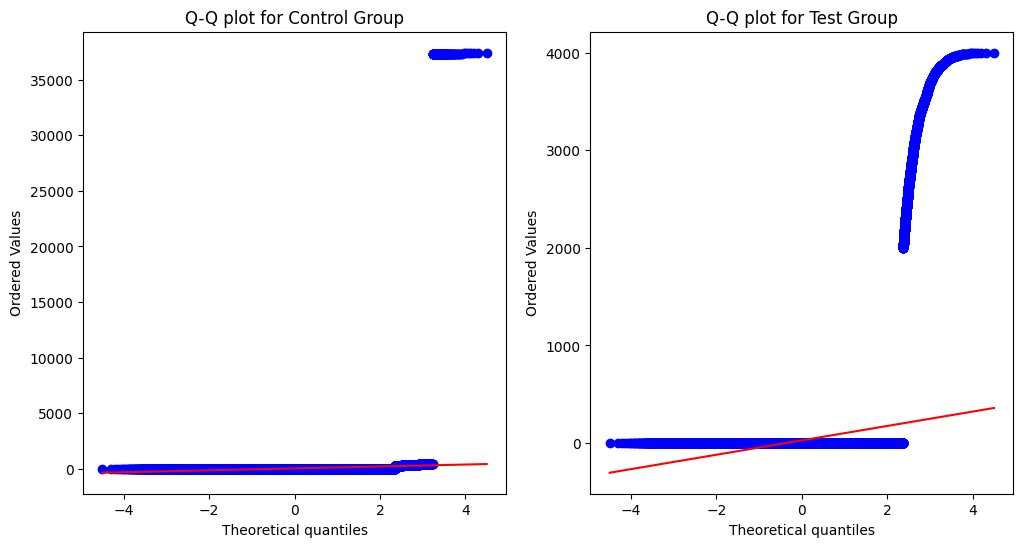

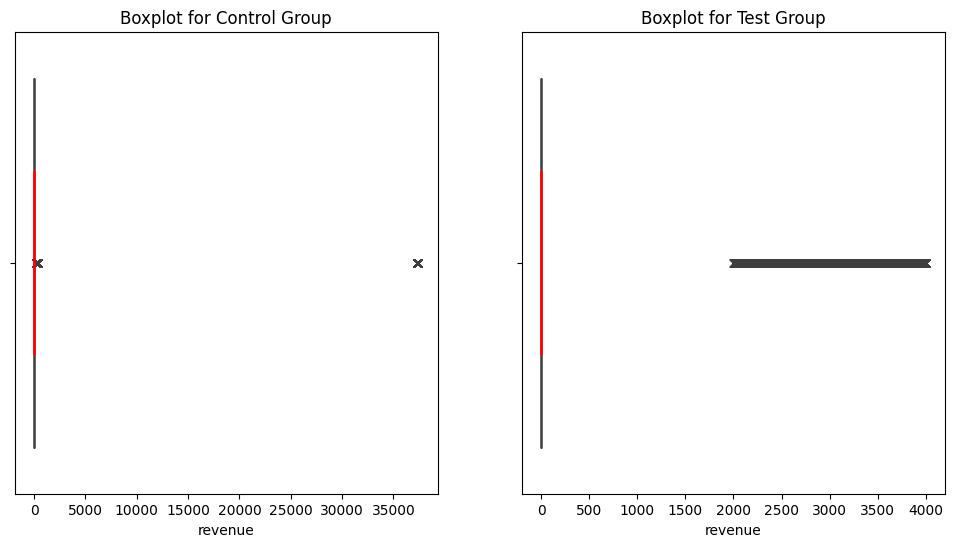

Outliers in Control Group: 72          351
341         290
385         250
416       37324
712         255
          ...  
404304      360
404315      262
404543      369
404602      251
404767      231
Name: revenue, Length: 1928, dtype: int64
Outliers in Test Group: 160       3797
377       3768
386       3527
551       2038
913       3902
          ... 
403843    3383
403994    2793
404161    2316
404193    2998
404525    3120
Name: revenue, Length: 1805, dtype: int64
Levene's test: stat = 0.3896289474701388 , p_value = 0.5324948591043842
95% confidence interval for control group: (21.399375659503516, 29.428063814428096)
95% confidence interval for test group: (25.500361473872644, 28.002211712684613)


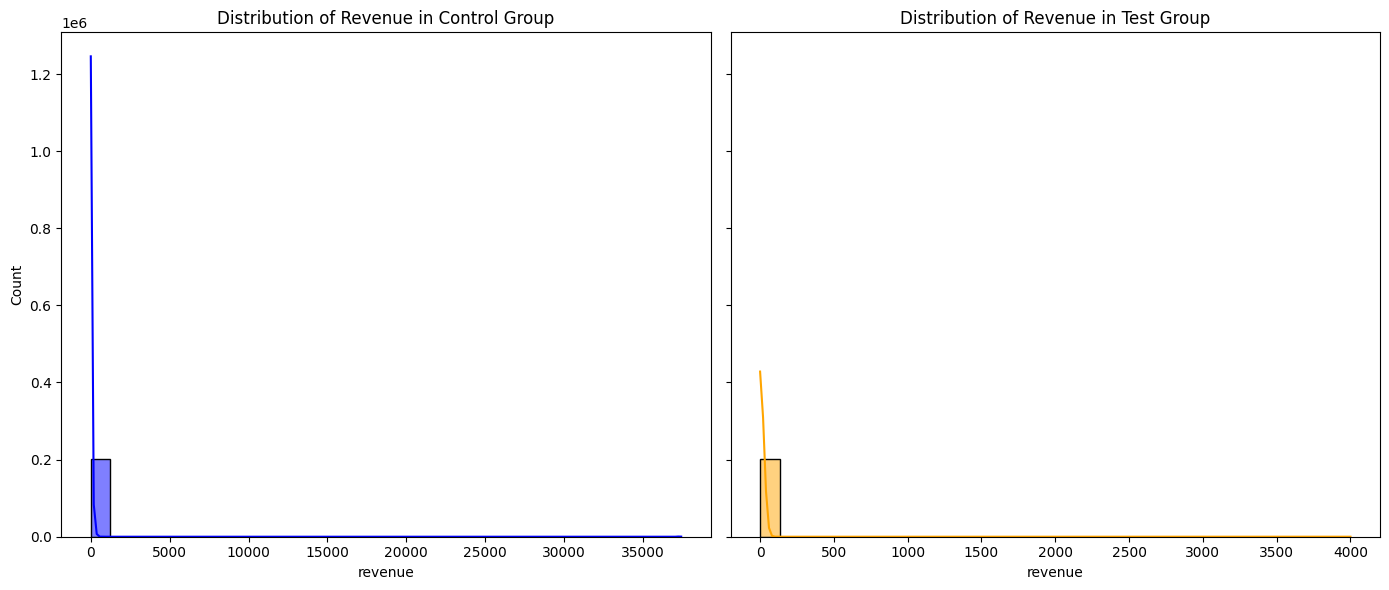

In [26]:
# Разделение данных на тестовую и контрольную группы
control_group = ab_test[ab_test['testgroup'] == 'a']
test_group = ab_test[ab_test['testgroup'] == 'b']

# Проверка на нормальность
# Используем тест D'Agostino и Pearson
print("D'Agostino and Pearson Test for Control Group:", stats.normaltest(control_group['revenue']))
print("D'Agostino and Pearson Test for Test Group:", stats.normaltest(test_group['revenue']))

# Q-Q Plot для визуальной проверки нормальности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
stats.probplot(control_group['revenue'], dist="norm", plot=plt)
plt.title('Q-Q plot for Control Group')

plt.subplot(1, 2, 2)
stats.probplot(test_group['revenue'], dist="norm", plot=plt)
plt.title('Q-Q plot for Test Group')
plt.show()

# Выявление выбросов
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(
    x=control_group['revenue'], 
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.3, .7, .9, .5)},
    medianprops={"color": "r", "linewidth": 2}
)
plt.title('Boxplot for Control Group')

plt.subplot(1, 2, 2)
sns.boxplot(
    x=test_group['revenue'], 
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.3, .7, .9, .5)},
    medianprops={"color": "r", "linewidth": 2}
)
plt.title('Boxplot for Test Group')
plt.show()

# Используем метод межквартильного размаха для выявления выбросов
def detect_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

print("Outliers in Control Group:", detect_outliers(control_group['revenue']))
print("Outliers in Test Group:", detect_outliers(test_group['revenue']))

# Проверка дисперсий на однородность (тест Левена)
levene_stat, levene_p = stats.levene(control_group['revenue'], test_group['revenue'])
print("Levene's test: stat =", levene_stat, ", p_value =", levene_p)

# Рассчитаем доверительные интервалы
control_mean = np.mean(control_group['revenue'])
test_mean = np.mean(test_group['revenue'])

control_std = np.std(control_group['revenue'], ddof=1)
test_std = np.std(test_group['revenue'], ddof=1)

confidence_interval_control = stats.t.interval(0.95, len(control_group)-1, loc=control_mean, scale=control_std / np.sqrt(len(control_group)))
confidence_interval_test = stats.t.interval(0.95, len(test_group)-1, loc=test_mean, scale=test_std / np.sqrt(len(test_group)))

print("95% confidence interval for control group:", confidence_interval_control)
print("95% confidence interval for test group:", confidence_interval_test)

# Улучшенная визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.histplot(control_group['revenue'], bins=30, kde=True, ax=axes[0], color='blue')
sns.histplot(test_group['revenue'], bins=30, kde=True, ax=axes[1], color='orange')

axes[0].set_title('Distribution of Revenue in Control Group')
axes[1].set_title('Distribution of Revenue in Test Group')

plt.tight_layout()
plt.show()

### Анализ результатов

#### Тесты Д'Агостино и Пирсона
**Контрольная группа:** 
- **Statistic:** 585152.73
- **P-value:** 0.0
    
**Тестовая группа:** 
- **Statistic:** 326622.39
- **P-value:** 0.0

Оба p-значения равны 0.0, что подтверждает значительное отклонение данных от нормального распределения.

#### Q-Q Plots (Графики нормальности)
- Данные сильно отклоняются от нормального распределения, что видно по отклонению точек от диагональной линии на графиках.

#### Высокие значения
- **Контрольная группа:** 1928 записей
- **Тестовая группа:** 1805 записей
- Оба набора данных имеют значительное количество высоких значений.

#### Тест Левена
- **Statistic:** 0.39
- **P-value:** 0.53
- Дисперсии в контрольной и тестовой группах можно считать равными, так как p-значение больше 0.05.

#### Доверительные интервалы (ARPU)
- **Контрольная группа:** (21.40, 29.43)
- **Тестовая группа:** (25.50, 28.00)
- Доверительные интервалы перекрываются, что может указывать на отсутствие значимой разницы между средними доходами на пользователя в обеих группах.

### Промежуточный вывод:

Анализ показал следующие ключевые моменты:

1. **Ненормальность распределения данных:** Оба p-значения тестов Д'Агостино и Пирсона равны 0.0, что подтверждает значительное отклонение данных от нормального распределения.
2. **Равенство дисперсий:** По результатам теста Левена (p-value = 0.53) дисперсии в контрольной и тестовой группах можно считать равными.
3. **Перекрытие доверительных интервалов:** Доверительные интервалы для ARPU в обеих группах перекрываются, что может свидетельствовать об отсутствии значимой разницы между средними доходами на пользователя.

Так как данные не являются нормальными и содержат высокие значения, рекомендуется использовать непараметрические тесты, такие как тест Манна-Уитни, для проверки гипотез. 

### Тест Манна-Уитни для ARPU 

### Причины выбора теста Манна-Уитни:

1. **Отклонение от нормального распределения:**
   - **Тесты Д'Агостино и Пирсона** показывают, что данные сильно отклоняются от нормального распределения.
   - **Q-Q графики** также подтверждают отклонение от нормальности.

2. **Тест Манна-Уитни (U-тест) для непараметрических данных:**
   - Этот тест не требует нормального распределения и сравнивает медианные значения двух независимых групп.
   - Он подходит для случаев, когда данные не соответствуют нормальному распределению, как в вашем случае.

In [27]:
# Применение теста Манна-Уитни
u_stat, p_value = stats.mannwhitneyu(
    ab_test[ab_test['testgroup'] == 'a']['revenue'],
    ab_test[ab_test['testgroup'] == 'b']['revenue']
)

# Рекомендация на основе метрик и p-value
if p_value < 0.05:
    print("Результаты значимы, выбираем группу с лучшими метриками.")
    # Вычисление ARPU для тестовой и контрольной групп
    arpu_test = ab_test[ab_test['testgroup'] == 'a']['revenue'].mean()
    arpu_control = ab_test[ab_test['testgroup'] == 'b']['revenue'].mean()
    
    if arpu_test > arpu_control:
        print("Тестовая группа показала лучшие результаты.")
    else:
        print("Контрольная группа показала лучшие результаты.")
else:
    print("Результаты не значимы")

print(f"Mann-Whitney U test p-value: {p_value}")

Результаты не значимы
Mann-Whitney U test p-value: 0.062697013160744


### Вывод по результатам теста Манна-Уитни

Результаты теста Манна-Уитни показали p-value равное 0.0627. Поскольку это значение больше уровня значимости 0.05, мы не можем отвергнуть нулевую гипотезу (H₀), которая утверждает, что нет статистически значимой разницы между тестовой и контрольной группами. Альтернативная гипотеза (H₁), предполагающая, что тестовая группа имеет статистически более высокий результат, не подтверждается.  

### Вывод и выбор гипотезы по анализу ARPU

Анализ показал следующие ключевые моменты:

1. **Ненормальность распределения данных:** Оба p-значения тестов Д'Агостино и Пирсона равны 0.0, что подтверждает значительное отклонение данных от нормального распределения.
2. **Равенство дисперсий:** По результатам теста Левена (p-value = 0.53) дисперсии в контрольной и тестовой группах можно считать равными.
3. **Перекрытие доверительных интервалов:** Доверительные интервалы для ARPU в обеих группах перекрываются, что может свидетельствовать об отсутствии значимой разницы между средними доходами на пользователя.
4. **Результаты теста Манна-Уитни:** p-value равен 0.0627, что больше уровня значимости 0.05. Это указывает на отсутствие статистически значимой разницы между тестовой и контрольной группами.

На основании всех этих результатов, нулевая гипотеза (H₀), утверждающая, что нет статистически значимой разницы между наборами акционных предложений по метрике ARPU, принимается.

### Анализ Conversion Rate

**Хи-квадрат тест (Chi-Square Test)**:
   - Этот тест проверяет, есть ли значимые различия в проценте конверсий (сколько пользователей совершили целевое действие) между контрольной и тестовой группами. Он идеально подходит для категориальных данных (конверсия/неконверсия) и не требует предположений о нормальном распределении данных.

#### Анализируем Conversion Rate 

In [28]:
# Данные для контрольной и тестовой групп
control_group_users = len(ab_test[ab_test['testgroup'] == 'a'])
control_group_conversions = len(ab_test[(ab_test['testgroup'] == 'a') & (ab_test['revenue'] > 0)])

test_group_users = len(ab_test[ab_test['testgroup'] == 'b'])
test_group_conversions = len(ab_test[(ab_test['testgroup'] == 'b') & (ab_test['revenue'] > 0)])

# Создание таблицы сопряженности
contingency_table = np.array([[control_group_conversions, control_group_users - control_group_conversions],
                              [test_group_conversions, test_group_users - test_group_conversions]])

# Проведение Chi-Square теста
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

control_conversion_rate = control_group_conversions / control_group_users
test_conversion_rate = test_group_conversions / test_group_users

print(f"Control Conversion Rate: {control_conversion_rate * 100:.2f}%")
print(f"Test Conversion Rate: {test_conversion_rate * 100:.2f}%")
print(f"Chi-square: {chi2}")
print(f"P-value: {p_value}")

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Различие в коэффициентах конверсии статистически значимо.")
else:
    print("Различие в коэффициентах конверсии не является статистически значимым.")

Control Conversion Rate: 0.95%
Test Conversion Rate: 0.89%
Chi-square: 4.374729521260405
P-value: 0.03647561892312609
Различие в коэффициентах конверсии статистически значимо.


### Вывод по проведенному тесту Хи-квадрат

Результаты анализа конверсии (CR) с помощью Хи-квадрат теста:

- **Коэффициент конверсии в контрольной группе**: 0.95%
- **Коэффициент конверсии в тестовой группе**: 0.89%
- **Chi-square значение**: 4.374729521260405
- **P-value**: 0.03647561892312609

**Интерпретация результатов**:
Так как p-value (0.0365) меньше уровня значимости (alpha = 0.05), мы можем заключить, что различие в коэффициентах конверсии между контрольной и тестовой группами является статистически значимым. Это означает, что наблюдаемая разница в конверсии не является случайной и с высокой вероятностью обусловлена изменениями, внесенными в тестовую группу.

### Принятая гипотеза

- **H₀ (Нулевая гипотеза):** Принята, так как наблюдаемая разница в коэффициенте конверсии (CR) между контрольной и тестовой группами, несмотря на статистическую значимость (p-value = 0.0365), указывает на худший результат в тестовой группе. Это, вместе с отсутствием значимого улучшения ARPU, не поддерживает обоснование для внедрения нового акционного предложения.

### Анализ ARPPU

#### Тест Манна-Уитни

**Причины выбора:**

1. **Нормальность распределения:**
   - Данные не распределены нормально, как это показали тесты Д'Агостино и Пирсона, а также графики нормальности (Q-Q plots). Тест Манна-Уитни не требует нормальности распределения и работает с ранговыми данными.

2. **Неравенство дисперсий:**
   - Дисперсии между группами можно считать равными (p-value теста Левена больше 0.05), что поддерживает использование теста Манна-Уитни. Тем не менее, тест Манна-Уитни не требует равенства дисперсий, что делает его более универсальным в условиях неидеальных данных.

3. **Тип данных:**
   - ARPPU является непрерывной переменной, и тест Манна-Уитни подходит для сравнения непрерывных данных между двумя независимыми группами, когда данные не соответствуют предположениям для параметрических тестов.

#### Анализируем ARPPU

In [29]:
# Данные для контрольной и тестовой групп
control_group_arppu = ab_test[(ab_test['testgroup'] == 'a') & (ab_test['revenue'] > 0)]['revenue']
test_group_arppu = ab_test[(ab_test['testgroup'] == 'b') & (ab_test['revenue'] > 0)]['revenue']

# Вычисление среднего ARPPU и стандартного отклонения для каждой группы
control_mean_arppu = np.mean(control_group_arppu)
test_mean_arppu = np.mean(test_group_arppu)

control_std_arppu = np.std(control_group_arppu, ddof=1)
test_std_arppu = np.std(test_group_arppu, ddof=1)

# Проведение теста Манна-Уитни
u_stat, p_value = mannwhitneyu(control_group_arppu, test_group_arppu, alternative='two-sided')

print(f"Control ARPPU Mean: {control_mean_arppu:.2f}")
print(f"Test ARPPU Mean: {test_mean_arppu:.2f}")
print(f"Control ARPPU Std Dev: {control_std_arppu:.2f}")
print(f"Test ARPPU Std Dev: {test_std_arppu:.2f}")
print(f"U-statistic: {u_stat:.2f}")
print(f"P-value: {p_value:.4f}")

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Различие в ARPPU между контрольной и тестовой группами статистически значимо.")
else:
    print("Различие в ARPPU между контрольной и тестовой группами не является статистически значимым.")

Control ARPPU Mean: 2664.00
Test ARPPU Mean: 3003.66
Control ARPPU Std Dev: 9049.04
Test ARPPU Std Dev: 572.62
U-statistic: 222015.00
P-value: 0.0000
Различие в ARPPU между контрольной и тестовой группами статистически значимо.


### Вывод по проведенному тесту Манна-Уитни

Результаты анализа ARPPU (Average Revenue Per Paying User) с помощью теста Манна-Уитни:

- **Среднее ARPPU в контрольной группе**: 2664.00
- **Среднее ARPPU в тестовой группе**: 3003.66
- **Стандартное отклонение ARPPU в контрольной группе**: 9049.04
- **Стандартное отклонение ARPPU в тестовой группе**: 572.62
- **U-статистика**: 222015.00
- **P-value**: 0.0000

**Интерпретация результатов**:
Так как p-value (0.0000) значительно меньше уровня значимости (alpha = 0.05), мы можем заключить, что различие в ARPPU между контрольной и тестовой группами является статистически значимым. Это означает, что наблюдаемая разница в среднем доходе на платящего пользователя не является случайной и с высокой вероятностью обусловлена изменениями, внесенными в тестовую группу.

### Принятая гипотеза

- **H₁ (Альтернативная гипотеза):** Разница в ARPPU между контрольной и тестовой группами является статистически значимой и связана с изменениями в тестовой группе. Результат теста Манна-Уитни (p-value = 0.0000) позволяет отклонить нулевую гипотезу (H₀), которая предполагала отсутствие значимого влияния изменений на ARPPU и объясняла различия случайными вариациями.

## **Итог:**

#### Результаты A/B теста

**ARPU**: Тестовая группа показывает незначительное увеличение ARPU (26.75) по сравнению с контрольной группой (25.41).

**Конверсия**: Конверсия в контрольной группе (0.95%) выше, чем в тестовой группе (0.89%).

**ARPPU**: Тестовая группа демонстрирует значительное улучшение ARPPU (3003.66) по сравнению с контрольной группой (2664.00).

#### Итоговое решение

На основании значительного улучшения ARPPU в тестовой группе, принято **гипотезу H₁**: новый набор акционных предложений показывает статистически значимое улучшение по одной из ключевых метрик. В связи с этим, **рекомендуется внедрить новое акционное предложение**, так как улучшение ARPPU указывает на реальную выгоду для компании.

## 🍂 Задание 3

### Текст задания:
- В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

- Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Для оценки результатов тематического события в игре, таких как "Plants & Gardens", можно использовать различные метрики, которые помогут понять, как событие повлияло на поведение игроков и их удовлетворенность. Вот основные метрики, которые стоит рассмотреть:

### 1. **Активность игроков**

- **Количество участников события**: Общее количество уникальных игроков, которые начали участие в событии.
- **Процент завершивших событие**: Доля участников, которые завершили событие, из общего числа начавших.

### 2. **Вовлеченность игроков**

- **Среднее время участия**: Среднее время, проведенное игроками в событии, от начала до завершения.
- **Количество уровней, пройденных за событие**: Среднее количество уровней, которые игроки проходили в рамках события.

### 3. **Успешность выполнения**

- **Процент успешных попыток**: Доля попыток, которые завершились успешно, из общего числа попыток.
- **Среднее количество попыток до успешного завершения**: Среднее количество попыток, которые игроки делали, чтобы успешно пройти уровень или событие в целом.

### 4. **Игровые достижения и награды**

- **Количество полученных наград**: Количество уникальных предметов или бонусов, полученных игроками в рамках события.
- **Стоимость полученных наград**: Общая стоимость или ценность наград, полученных игроками.

### 5. **Финансовые метрики**

- **Средний доход на игрока (ARPU)**: Средний доход, полученный от участников события.
- **Общие доходы от события**: Общий доход, полученный от всех участников события.

### 6. **Поведенческие метрики**

- **Retention (удержание) после события**: Как событие повлияло на удержание игроков в игре после завершения события. Например, процент игроков, вернувшихся в игру в течение 7, 14, 30 дней после события.
- **Изменение в частоте игровых сеансов**: Как событие повлияло на частоту игровых сеансов до и после события.

### 7. **Пользовательская удовлетворенность**

- **Оценки и отзывы**: Отзывы и оценки игроков о событии, которые могут быть собраны через опросы или внутренние механизмы оценки в игре.

### Изменение метрик при усложнении механики событий

Если в следующем событии механика усложняется, и при каждой неудачной попытке игрок будет откатываться на несколько уровней назад, метрики оценки могут измениться следующим образом:

1. **Успешность выполнения**:
   - **Процент успешных попыток** может снизиться из-за увеличения сложности.
   - **Среднее количество попыток до успешного завершения** может возрасти, так как игрокам потребуется больше попыток для прохождения уровней.

2. **Активность игроков**:
   - **Количество участников события** может измениться в зависимости от того, насколько сложной и привлекательной будет новая механика. Возможен как рост интереса, так и снижение активности.

3. **Вовлеченность игроков**:
   - **Среднее время участия** может увеличиться из-за того, что игрокам потребуется больше времени для прохождения уровней и событий.
   - **Количество уровней, пройденных за событие** может снизиться, поскольку игроки могут застрять на сложных уровнях.

4. **Финансовые метрики**:
   - **Средний доход на игрока (ARPU)** может увеличиться, если сложность приводит к большему количеству покупок дополнительных попыток или других внутриигровых покупок.
   - **Общие доходы от события** могут увеличиться или снизиться в зависимости от того, как сложность влияет на общую активность и покупки.

5. **Пользовательская удовлетворенность**:
   - **Оценки и отзывы** могут варьироваться. Некоторые игроки могут оценить усложнение как вызов, другие могут стать разочарованными из-за повышения сложности.

### Рекомендации по анализу результатов

1. **Анализируйте изменения**: Сравните данные по метрикам до и после изменений в механике события, чтобы понять влияние новых условий на игрока.

2. **Сегментируйте данные**: Разделите данные на группы по уровню сложности или типам игроков, чтобы получить более точные инсайты.

3. **Используйте A/B тестирование**: Проведите A/B тестирование различных версий механики событий, чтобы определить, какие изменения наиболее эффективно влияют на вовлеченность и удовлетворенность игроков.

Эти шаги помогут вам лучше понять результаты события и оптимизировать будущие события для повышения удовлетворенности и вовлеченности игроков.

# ❄️ Этап 4: Заключение


### Заключение по проекту

### 1. Анализ Retention

**Первоначальное удержание**:
- Пользователи активно возвращаются в первый месяц после регистрации.

**Снижение Retention**:
- После первого месяца наблюдается значительное снижение удержания, что может указывать на потенциальные проблемы с продуктом.

**Стабилизация**:
- Удержание стабилизируется на уровне 4-5% с 4-5 месяцев и снижается до 2-3% после 20 дней.

### 2. Результаты A/B теста

**ARPU**:
- **Контрольная группа**: 25.41
- **Тестовая группа**: 26.75
- **Вывод**: Тестовая группа показывает незначительное увеличение ARPU, разница не является статистически значимой.

**Конверсия**:
- **Контрольная группа**: 0.95%
- **Тестовая группа**: 0.89%
- **Вывод**: Конверсия в контрольной группе выше, разница значима, что означает, что в тестовой группе меньше пользователей завершают покупку.

**ARPPU**:
- **Контрольная группа**: 2664.00
- **Тестовая группа**: 3003.66
- **Вывод**: Тестовая группа демонстрирует значительное и статистически значимое улучшение ARPPU.

#### Итоговое решение по результаты A/B теста

На основе значительного улучшения ARPPU в тестовой группе принято **гипотезу H₁**, что новый набор акционных предложений показывает статистически значимое улучшение. **Рекомендуется внедрить новое акционное предложение**, так как повышение ARPPU указывает на реальную выгоду для компании.

### 3. Plants & Gardens
#### Оценка тематического события "Plants & Gardens"

1. **Активность и вовлеченность**
   - Количество участников и процент завершивших.
   - Среднее время участия и количество пройденных уровней.

2. **Успешность выполнения**
   - Процент успешных попыток и среднее количество попыток до успеха.

3. **Игровые достижения и финансовые метрики**
   - Количество и стоимость наград.
   - Средний доход на игрока (ARPU) и общие доходы.

4. **Поведенческие метрики и удовлетворенность**
   - Удержание после события и частота игровых сеансов.
   - Оценки и отзывы.

#### Изменения при усложнении механики

- **Успешность выполнения**: Снижение процента успешных попыток и увеличение попыток до успеха.
- **Активность и вовлеченность**: Изменения в количестве участников и времени участия.
- **Финансовые метрики**: Возможное изменение ARPU и общих доходов.
- **Удовлетворенность**: Изменения в оценках и отзывах.

#### Рекомендации

1. **Анализируйте изменения**: Сравните метрики до и после изменений.
2. **Сегментируйте данные**: По сложности и типам игроков.
3. **Используйте A/B тестирование**: Для проверки разных механик.